# Main Model for Handwritten Text Synthesis GAN

This model will consist of 4 major networks, following the general architecture of an GAN.

1. Encoder: Produces an embedding that will be concatenated with the noise vector.
2. Generator: Taking noise vector as input and the text embedding to produce an 128x2048 image.
3. Discriminator: Trained alternating with generator input and ground-truth input, binary classification real or fake.
4. Recognizer: Taking image as input, produce a vector representation of the text.

## Import the required libraries:

In [55]:
import csv
import datetime
import os
import random
import re

import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch_fidelity
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.nn.utils.spectral_norm import spectral_norm
from torch.utils.data import DataLoader, Dataset, RandomSampler, Subset, random_split
from torchmetrics.image.fid import FrechetInceptionDistance
from torchvision import datasets
from torchvision.io import read_image
from torchvision.transforms import Grayscale, Resize, ToTensor
from torchvision.transforms.functional import InterpolationMode

## Data Loading

### Helper Functions (Run once only to format data)

In [56]:
SCALE_HEIGHT = 32
SCALE_WIDTH = SCALE_HEIGHT*16

def preprocess_lines(data_root):
    """
    Creates a new `.txt` file `lines_improved.txt` that will be used
    for querying. This new `.txt` file contains all info necessary
    for the functionality of this project.
    """

    original_path = os.path.join(data_root, "lines.txt")
    improved_path = os.path.join(data_root, "lines_improved.txt")
    fi = open(improved_path, "w")

    # Some variables for tracking
    num_samples = 0
    valid_samples = 0
    
    # Loop through "lines.txt"
    with open(original_path, "r") as fo:
        headers = ["image_id", "image_path", "image_pt_path", "graylevel", "original_height", "original_width", "transcription", "transcription_len"]

        # First write the headers at the top of the file
        fi.writelines("\t".join(headers) + "\n")

        # Skip the intro stuff
        for line in fo.readlines():
            if line.startswith("#"):
                continue

            # Valid lines, not the intro_text
            line_items = line.strip().split(" ")  # `strip()` to remove newlines

            # The actual items (we extract the important ones)
            image_id = line_items[0]
            status = line_items[1]
            graylevel = int(line_items[2])
            transcription = " ".join(line_items[8:])  # Some data has whitespace, we join string till the end

            # Skip error images
            if status == "err":
                continue
        
            # Alphanumeric + common punctuation regex
            # Returns None if no match
            # 26 + 26 + 10 + 9 + 1 = 72
            # Spaces might be included as well
            # Punctuation include , ! ? ' " , : ; -
            if re.fullmatch("[a-zA-Z0-9.!?'\",:;| -]*", transcription) is None:
                continue

            # Now we have valid transcription
            num_samples += 1

            # We get the `.png` image path
            inp = image_id.split("-")  # `inp` stands for image name parts
            image_path_head = os.path.join(data_root, "lines", inp[0], f"{inp[0]}-{inp[1]}")
            image_path_tail = f"{image_id}.png"
            image_path = os.path.join(image_path_head, image_path_tail)
            
            # Read image, gets its dimensions, perform processing operations, and other stuff
            tmp_image = cv.imread(os.path.join(image_path_head, image_path_tail), cv.IMREAD_GRAYSCALE)  # Removes the channel dimension
            height, width = tmp_image.shape

            # Scaling calculations
            # If width * scale >= desired length (>= to be safe)
            # Condition here to speed up overall processing time
            if width * (SCALE_HEIGHT/height) >= SCALE_WIDTH:
                continue

            resized_tensor = process_image(tmp_image, graylevel)
            image_pt_path = os.path.join(image_path_head, f"{image_id}.pt")
            torch.save(resized_tensor, image_pt_path)

            # A fully valid image
            # Separate by underscores because `transcription` has spaces so we can't split by spaces
            fi.writelines(f"{image_id}\t{image_path}\t{image_pt_path}\t{graylevel}\t{height}\t{width}\t{transcription}\t{len(transcription)}\n")
            valid_samples += 1
        
        fi.close()
    
    print("# samples:", num_samples)
    print("Valid samples:", valid_samples)


def process_image(cv_image, graylevel):
    """
    Takes in a grayscale image that OpenCV read of shape (H, W) of type uint8
    Returns a PyTorch tensor of shape (1, 32, W'), where W' is the scaled width
    This tensor is padded and effectively thresholded
    """

    # Scaling factor
    height, width = cv_image.shape
    scale = SCALE_HEIGHT/height
    scaled_width = int(width*scale)

    # Trick here is to apply threshold before resize and padding
    # This allows OpenCV resizing to create a cleaner output image
    # 2nd return value is the thresholded image
    output = cv.threshold(cv_image, graylevel, 255, cv.THRESH_BINARY)[1]

    # INTER_AREA recommended for sizing down
    output = cv.resize(output, (scaled_width, SCALE_HEIGHT), interpolation=cv.INTER_AREA)

    # Turn it back to a tensor and map to [0, 1]
    output = torch.from_numpy(output).unsqueeze(0).type(torch.float32)
    output = (output-output.min()) / (output.max()-output.min())
    
    # Add padding
    _, _, resized_height = output.shape
    padding_to_add = SCALE_WIDTH - resized_height
    output = F.pad(output, (0, padding_to_add), value=1.0)

    return output

# Uncomment this if your data isn't processed yet
# preprocess_lines("./data/")

### Important Dict (Run everytime before training)

In [57]:
# Sorted by ascii code
valid = [
    ' ', '!', '"', "'", ',', '-', '.',
    '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 
    ':', ';', '?', 
    'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z',
    'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z'
]
# Enumerate from 1 to save space for padding
char_to_int = {v: i for i, v in enumerate(valid, 1)}
int_to_char = {i: v for i, v in enumerate(valid, 1)}

In [58]:
class LineDataset(Dataset):
    def __init__(self, lines_improved_dir, ty=None):
        """
        params:
            lines_improved_dir: path to the `lines_improved.txt` file
            ty: type of the dataset "txt", "img" for text dataset or image dataset.
        """
        
        # Dataframe containing the stuff in `lines_improved.txt`
        self.lines_df = pd.read_csv(lines_improved_dir, sep="\t", quoting=csv.QUOTE_NONE)

        # Class properties
        self.ty = ty  # Type of dataset (lines, images, or both)
        self.max_transcription_len = max(self.lines_df["transcription_len"])

        # Temp variables...
        length = self.lines_df.shape[0]
        line_datas = self.lines_df.iloc
        ret_texts = [line_datas[i]["transcription"].replace('|', ' ') for i in range(length)]
        ret_ctois = [torch.tensor([char_to_int[char] for char in ret_texts[i]]) for i in range(length)]

        # ...for the important data
        if self.ty in ("txt", None):  # Added this condition to speed thigns up if only text
            self.ret_ctoi_paddeds = [F.pad(ret_ctois[i], pad=(0, self.max_transcription_len-len(ret_ctois[i]))) for i in range(length)]
        if self.ty in ("img", None):
            self.ret_images = [torch.load(line_datas[i]["image_pt_path"]) for i in range(length)]

    def __len__(self):
        return len(self.lines_df)
    
    def __getitem__(self, index):
        # Different type of individual loaders
        if self.ty == "txt":
            return self.ret_ctoi_paddeds[index]
        elif self.ty == "img":
            return self.ret_images[index]
        else:
            return self.ret_images[index], self.ret_ctoi_paddeds[index]

In [59]:
line_transcription_dataset = LineDataset("./data/lines_improved.txt", ty="txt")
line_image_dataset = LineDataset("./data/lines_improved.txt", ty="img")
line_dataset = LineDataset("./data/lines_improved.txt")

# Don't change this, we want to maintain consistent split
torch.manual_seed(12345678)  # DO NOT REMOVE THIS LINE
line_transcription_dataset_train, line_transcription_dataset_val = random_split(line_transcription_dataset, [0.8, 0.2])
line_image_dataset_train, line_image_dataset_val = random_split(line_image_dataset, [0.8, 0.2])
line_dataset_train, line_dataset_val = random_split(line_dataset, [0.8, 0.2])

# To train on a small dataset
line_transcription_dataset_train = Subset(line_transcription_dataset_train, range(100))
line_transcription_dataset_val = Subset(line_transcription_dataset_val, range(20))

line_image_dataset_train = Subset(line_image_dataset_train, range(100))
line_image_dataset_val = Subset(line_image_dataset_val, range(20))

# line_transcription_dataset_train, line_transcription_dataset_val, _ = random_split(line_transcription_dataset, [0.005, 0.005, 0.99])
# line_image_dataset_train, line_image_dataset_val, _ = random_split(line_image_dataset, [0.005, 0.005, 0.99])
# line_dataset_train, line_dataset_val = random_split(line_dataset, [0.0025, 0.9975])

print("lines")
print(len(line_transcription_dataset_train), len(line_transcription_dataset_val))
print("images")
print(len(line_image_dataset_train), len(line_image_dataset_val))
print("both")
print(len(line_dataset_train), len(line_dataset_val))


KeyboardInterrupt: 

torch.Size([1, 32, 512])
torch.Size([32, 512])
tensor([[[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         ...,
         [0.0000, 0.6196, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [0.4549, 0.9961, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]]])


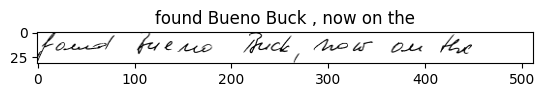

In [ ]:
image, label = line_dataset_train[283]
print(image.shape)
plt.title("".join([int_to_char[int(val)] for val in label[label.nonzero()]]))
print(image.squeeze(0).shape)
plt.imshow(image.squeeze(0), cmap='gray')
label, "".join([int_to_char[int(val)] for val in label[label.nonzero()]])
# line_dataset.lines_df.iloc[798]
print(image)

In [ ]:
# # plt.imshow(line_dataset.lines_df["image_path"])
# image = read_image(line_dataset.lines_df["image_path"].iloc[283]).squeeze(0)
# plt.imshow(image, cmap="gray")

In [ ]:
# plt.imshow(line_image_dataset[1000], cmap="gray")

In [ ]:
# for i in DataLoader(line_image_dataset, batch_size=64, shuffle=True):
#     print(i.shape)
#     ...

Define Key Functions

In [ ]:
"""Dataloading Functions"""
"""Datasaving Functions"""

"""Plotting Functions"""
"""Evaluation Functions"""
def calculate_gan_loss_and_accuracies(generator, encoder, discriminator, recognizer, 
                                  real_image_loader, input_text_loader, 
                                  batch_size=64, adversarial_loss_function=nn.BCELoss(), recognizer_loss_function=nn.CTCLoss(),
                                  device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')):
    """
    Calculates the loss for the GAN
    
    Params:
        generator: The generator model
        encoder: The encoder model
        discriminator: The discriminator model
        recognizer: The recognizer model
        real_image_loader: The dataloader for real images
        input_text_loader: The dataloader for input text
        batch_size: The batch size to use
        adversarial_loss_function: The adversarial loss function to use
        recognizer_loss_function: The recognizer loss function to use

    Returns:
        generator_and_encoder_loss: The loss for the generator and encoder
        discriminator_loss: The loss for the discriminator
    """
    fid = FrechetInceptionDistance(feature=2048, reset_real_features=False)
    for real_image_batch in real_image_loader:
        fid.update((real_image_batch.cpu()*255).type(torch.uint8).repeat(1, 3, 1, 1), real=True)

    generator_and_encoder_loss = 0
    discriminator_loss = 0
    discriminator_accuracy = 0
    with torch.no_grad():
        for i, (real_image_batch, input_text_batch) in enumerate(zip(real_image_loader, input_text_loader)):
            real_image_batch = real_image_batch.to(device)
            input_text_batch = input_text_batch.to(device)

            # generate noise of N x noise_dim
            noise = torch.randn(len(input_text_batch), generator.noise_dim).to(device)

            # Use encoder and generator to generate fake images
            text_embedding = encoder(input_text_batch)
            fake_image_batch = generator(noise, text_embedding)

            # train discriminator
            discriminator_output_for_real_images = discriminator(real_image_batch)
            discriminator_output_for_fake_images = discriminator(fake_image_batch)
            label_for_real_images = torch.ones_like(discriminator_output_for_real_images).to(device)
            label_for_fake_images = torch.zeros_like(discriminator_output_for_fake_images).to(device)
            real_images_loss = adversarial_loss_function(discriminator_output_for_real_images, label_for_real_images)
            fake_images_loss = adversarial_loss_function(discriminator_output_for_fake_images, label_for_fake_images)
            discriminator_loss = (real_images_loss + fake_images_loss) / 2
            discriminator_loss += discriminator_loss.item()
            discriminator_accuracy += (torch.sum(discriminator_output_for_real_images >= 0.5).item() + torch.sum(discriminator_output_for_fake_images < 0.5).item()) / (2 * batch_size)

            # train generator
            
            adversarial_loss = adversarial_loss_function(discriminator_output_for_fake_images, label_for_real_images)
            # recognizer_outputs = recognizer(fake_image_batch)
            # recognizer_loss = recognizer_loss_function(recognizer_outputs, input_text_batch)
            
            # balance the losses from different sources, according to https://arxiv.org/pdf/1903.00277.pdf
            adversarial_loss_mean, adversarial_loss_std = torch.mean(adversarial_loss), torch.std(adversarial_loss)
            # recognizer_loss_mean, recognizer_loss_std = torch.mean(recognizer_loss), torch.std(recognizer_loss)
            # recognizer_loss = loss_balancing_alpha * (adversarial_loss_std / recognizer_loss_std) * (recognizer_loss - recognizer_loss_mean) + adversarial_loss_mean
            
            generator_loss = adversarial_loss #+ recognizer_loss
            generator_and_encoder_loss += generator_loss.item()

            # calculate fid
            fid.update((real_image_batch.cpu()*255).type(torch.uint8).repeat(1, 3, 1, 1), real=True)
            fid.update((fake_image_batch.cpu()*255).type(torch.uint8).repeat(1, 3, 1, 1), real=False)

    generator_and_encoder_error = fid.compute().item()
    fid.reset()
    discriminator_accuracy /= len(real_image_loader)
    generator_and_encoder_loss /= len(real_image_loader)
    discriminator_loss /= len(input_text_loader)

    return generator_and_encoder_loss, discriminator_loss, generator_and_encoder_error, discriminator_accuracy

"""Training Functions"""
def train_recognizer(recognizer, train_line_loader, val_line_loader, batch_size=64, learning_rate=2e-4, betas=(0, 0.999), num_epochs=30):
    # only train on real images
    # also save model, plot graphs, save graphs
    pass

def train_gan(generator, encoder, discriminator, recognizer, 
              train_real_image_dataset, val_real_image_dataset, 
              train_input_text_dataset, val_input_text_dataset, 
              batch_size=64, learning_rate=2e-4, betas=(0, 0.999), num_epochs=30, loss_balancing_alpha=1,
              num_generator_updates_per_discriminator_update=1):
    # Note, the generator and discriminator should be spectrally normalized before training
    # TODO: load dataloader with batch size batch_size

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    # device = torch.device('cpu')
    print(device)
    generator = generator.to(device)
    encoder = encoder.to(device)
    discriminator = discriminator.to(device)
    # recognizer.to(device)
    
    train_real_image_loader = DataLoader(train_real_image_dataset, batch_size=batch_size, shuffle=True)
    val_real_image_loader = DataLoader(val_real_image_dataset, batch_size=batch_size, shuffle=True)
    train_input_text_loader = DataLoader(train_input_text_dataset, batch_size=batch_size, shuffle=True)
    val_input_text_loader = DataLoader(val_input_text_dataset, batch_size=batch_size, shuffle=True)

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate, betas=betas)
    generator_optimizer = optim.Adam(generator.parameters(), lr=learning_rate, betas=betas)
    discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=learning_rate, betas=betas)
    
    adversarial_loss_function = nn.BCELoss()  # discriminator already has sigmoid
    # recognizer_loss_function = nn.CTCLoss()  # TODO ensure recognizer's output fits the input of this loss function
    saving_filenames = {
        "encoder": os.path.join("main_model", "model_snapshots", f"{datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}_bs{batch_size}_lr{learning_rate}_betas{betas}_encoder"),
        "generator": os.path.join("main_model", "model_snapshots", f"{datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}_bs{batch_size}_lr{learning_rate}_betas{betas}_generator"),
        "discriminator": os.path.join("main_model", "model_snapshots", f"{datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}_bs{batch_size}_lr{learning_rate}_betas{betas}_discriminator"), 
        "losses": os.path.join("main_model", "model_training_information", f"{datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}_bs{batch_size}_lr{learning_rate}_betas{betas}_losses"),
        "accuracies": os.path.join("main_model", "model_training_information", f"{datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}_bs{batch_size}_lr{learning_rate}_betas{betas}_accuracies")
        }

    best_generator_and_encoder_val_loss = float('inf')
    best_discriminator_val_loss = float('inf')
    best_generator_and_encoder_val_error = 0
    best_discriminator_val_accuracy = 0
    saved_generator_and_encoder_models_epochs = []
    saved_discriminator_models_epochs = []

    generator_and_encoder_train_losses = []
    discriminator_train_losses = []
    generator_and_encoder_train_accuracies = []
    discriminator_train_accuracies = []
    generator_and_encoder_val_losses = []
    discriminator_val_losses = []
    generator_and_encoder_val_accuracies = []
    discriminator_val_accuracies = []

    # FID: https://torchmetrics.readthedocs.io/en/stable/image/frechet_inception_distance.html
    fid = FrechetInceptionDistance(feature=2048, reset_real_features=False)
    image_count = 0
    for real_image_batch in train_real_image_loader:
        image_count += len(real_image_batch)
        print("fid load image_count", image_count)
        fid.update((real_image_batch.cpu()*255).type(torch.uint8).repeat(1, 3, 1, 1), real=True)

    for epoch in range(num_epochs):
        display_images = []

        generator_and_encoder_train_loss = 0
        discriminator_train_loss = 0
        discriminator_train_accuracy = 0

        for i, (real_image_batch, input_text_batch) in enumerate(zip(train_real_image_loader, train_input_text_loader)):
            print("epoch", epoch, "batch", i)
            print("real_image_batch.shape", real_image_batch.shape)
            print("input_text_batch.shape", input_text_batch.shape)

            real_image_batch = real_image_batch.to(device)
            input_text_batch = input_text_batch.to(device)

            # generate noise of N x noise_dim
            noise = torch.randn(len(input_text_batch), generator.noise_dim).to(device)

            # Use encoder and generator to generate fake images
            text_embedding = encoder(input_text_batch)
            print(noise.shape, text_embedding.shape)
            fake_image_batch = generator(noise, text_embedding)

            # display random image from the batch
            plt.imshow(fake_image_batch.cpu().detach().numpy()[0].squeeze(0), cmap='gray')
            plt.show()

            # Only train discriminator every num_generator_updates_per_discriminator_update iterations
            if i % num_generator_updates_per_discriminator_update == 0:
                # train discriminator
                discriminator_optimizer.zero_grad()
                discriminator_output_for_real_images = discriminator(real_image_batch)
                discriminator_output_for_fake_images = discriminator(fake_image_batch.detach())  # added detatch to prevent gradients from flowing back to generator
                label_for_real_images = torch.ones_like(discriminator_output_for_real_images).to(device)*0.99  # To prevent discriminator from getting too confident
                label_for_fake_images = torch.zeros_like(discriminator_output_for_fake_images).to(device)+0.01  # To prevent discriminator from getting too confident
                real_images_loss = adversarial_loss_function(discriminator_output_for_real_images, label_for_real_images)
                fake_images_loss = adversarial_loss_function(discriminator_output_for_fake_images, label_for_fake_images)
                discriminator_loss = real_images_loss + fake_images_loss
                discriminator_loss.backward()  # retain_graph=True because we will use the same discriminator for the generator
                
                # Gradient clipping to prevent exploding gradients
                torch.nn.utils.clip_grad_norm_(discriminator.parameters(), max_norm=0.5)
                
                discriminator_optimizer.step()
                discriminator_train_loss += discriminator_loss.item()
                discriminator_train_accuracy += (torch.sum(discriminator_output_for_real_images > 0.5) + torch.sum(discriminator_output_for_fake_images < 0.5)) / (2 * batch_size)
                print(discriminator_output_for_fake_images)
                print(discriminator_output_for_real_images)

            # train generator
            generator_optimizer.zero_grad()
            encoder_optimizer.zero_grad()
            # # generate noise of N x noise_dim
            # noise = torch.randn(len(input_text_batch), generator.noise_dim).to(device)
            # # Use encoder and generator to generate fake images
            # text_embedding = encoder(input_text_batch)
            # fake_image_batch = generator(noise, text_embedding)
            # # display random image from the batch
            # plt.imshow(fake_image_batch.cpu().detach().numpy()[0].squeeze(0), cmap='gray')
            # plt.show()
            discriminator_output_for_fake_images = discriminator(fake_image_batch)
            adversarial_loss = adversarial_loss_function(discriminator_output_for_fake_images, torch.ones_like(discriminator_output_for_real_images).to(device)*0.99)  # note that we want the fake images to be classified as real, also the *0.99 is to prevent generator from getting too confident
            print(torch.sum(discriminator_output_for_fake_images > 0.5))
            print(adversarial_loss)
            print(discriminator_output_for_fake_images)
            # recognizer_outputs = recognizer(fake_image_batch)
            # recognizer_loss = recognizer_loss_function(recognizer_outputs, input_text_batch)
            
            # balance the losses from different sources, according to https://arxiv.org/pdf/1903.00277.pdf
            adversarial_loss_mean, adversarial_loss_std = torch.mean(adversarial_loss), torch.std(adversarial_loss)
            # recognizer_loss_mean, recognizer_loss_std = torch.mean(recognizer_loss), torch.std(recognizer_loss)
            # recognizer_loss = loss_balancing_alpha * (adversarial_loss_std / recognizer_loss_std) * (recognizer_loss - recognizer_loss_mean) + adversarial_loss_mean
            
            generator_loss = adversarial_loss #+ recognizer_loss
            generator_loss.backward()
            generator_optimizer.step()
            encoder_optimizer.step()
            generator_and_encoder_train_loss += generator_loss.item()
            
            # calculate FID
            fid.update((fake_image_batch.cpu()*255).type(torch.uint8).repeat(1, 3, 1, 1), real=False)

            # display_images.append(fake_image_batch[random.randint(0, len(fake_image_batch) - 1)].detach().numpy())

        # plot the collection of display_images, all are greyscale
        # display_images = np.array(display_images)
        # display_images = np.transpose(display_images, (0, 2, 3, 1))
        # display_images = np.squeeze(display_images)
        # plt.figure(figsize=(10, 10))
        # for i in range(25):
        #     plt.subplot(5, 5, i + 1)
        #     plt.imshow(display_images[i], cmap='gray')
        #     plt.axis('off')
        # plt.tight_layout()
        # plt.show()
        # plt.clf()


        # Tally up losses and accuracies
        generator_and_encoder_train_loss /= len(train_real_image_loader)
        discriminator_train_loss /= len(train_real_image_loader)
        generator_and_encoder_train_error = fid.compute().item()
        fid.reset()
        discriminator_train_accuracy /= len(train_real_image_loader)
        generator_and_encoder_train_losses.append(generator_and_encoder_train_loss)
        discriminator_train_losses.append(discriminator_train_loss)
        generator_and_encoder_train_accuracies.append(generator_and_encoder_train_error)
        discriminator_train_accuracies.append(discriminator_train_accuracy)

        generator_and_encoder_val_loss, discriminator_val_loss, generator_and_encoder_val_error, discriminator_val_accuracy = calculate_gan_loss_and_accuracies(generator, encoder, discriminator, recognizer, val_real_image_loader, val_input_text_loader, batch_size=batch_size)
        generator_and_encoder_val_losses.append(generator_and_encoder_val_loss)
        discriminator_val_losses.append(discriminator_val_loss)
        generator_and_encoder_val_accuracies.append(generator_and_encoder_val_error)
        discriminator_val_accuracies.append(discriminator_val_accuracy)

        print(f"Epoch {epoch}:\n\tGenerator and encoder train loss: {generator_and_encoder_train_loss}\n\tDiscriminator train loss: {discriminator_train_loss}\n\tGenerator and encoder train accuracy: {generator_and_encoder_train_error}\n\tDiscriminator train accuracy: {discriminator_train_accuracy}\n\tGenerator and encoder val loss: {generator_and_encoder_val_loss}\n\tDiscriminator val loss: {discriminator_val_loss}\n\tGenerator and encoder val accuracy: {generator_and_encoder_val_error}\n\tDiscriminator val accuracy: {discriminator_val_accuracy}")

        # Save models, only if they are better than the previous best
        if generator_and_encoder_val_loss < best_generator_and_encoder_val_loss:
            best_generator_and_encoder_val_loss = generator_and_encoder_val_loss
            saved_generator_and_encoder_models_epochs.append(epoch)
            torch.save(generator.state_dict(), f"{saving_filenames['generator']}_epoch{epoch}.pt")
            torch.save(encoder.state_dict(), f"{saving_filenames['encoder']}_epoch{epoch}.pt")
            torch.save(discriminator.state_dict(), f"{saving_filenames['discriminator']}_epoch{epoch}.pt")
        if discriminator_val_loss < best_discriminator_val_loss:
            best_discriminator_val_loss = discriminator_val_loss
            saved_discriminator_models_epochs.append(epoch)
            torch.save(generator.state_dict(), f"{saving_filenames['generator']}_epoch{epoch}.pt")
            torch.save(encoder.state_dict(), f"{saving_filenames['encoder']}_epoch{epoch}.pt")
            torch.save(discriminator.state_dict(), f"{saving_filenames['discriminator']}_epoch{epoch}.pt")
        if generator_and_encoder_val_error < best_generator_and_encoder_val_error:
            best_generator_and_encoder_val_error = generator_and_encoder_val_error
            saved_generator_and_encoder_models_epochs.append(epoch) if epoch not in saved_generator_and_encoder_models_epochs else None
            torch.save(generator.state_dict(), f"{saving_filenames['generator']}_epoch{epoch}.pt")
            torch.save(encoder.state_dict(), f"{saving_filenames['encoder']}_epoch{epoch}.pt")
            torch.save(discriminator.state_dict(), f"{saving_filenames['discriminator']}_epoch{epoch}.pt")
        if discriminator_val_accuracy > best_discriminator_val_accuracy:
            best_discriminator_val_accuracy = discriminator_val_accuracy
            saved_discriminator_models_epochs.append(epoch) if epoch not in saved_discriminator_models_epochs else None
            torch.save(generator.state_dict(), f"{saving_filenames['generator']}_epoch{epoch}.pt")
            torch.save(encoder.state_dict(), f"{saving_filenames['encoder']}_epoch{epoch}.pt")
            torch.save(discriminator.state_dict(), f"{saving_filenames['discriminator']}_epoch{epoch}.pt")

        # plot title
        plt.title("generator and encoder losses")
        # plot x axis label
        plt.xlabel("epoch")
        # plot y axis label
        plt.ylabel("loss")
        # plot the epoch vs the loss
        plt.plot(range(epoch+1), generator_and_encoder_train_losses, label="train")
        plt.plot(range(epoch+1), generator_and_encoder_val_losses, label="val")
        # plot the saved models as dots
        plt.scatter(saved_generator_and_encoder_models_epochs, [generator_and_encoder_val_losses[i] for i in saved_generator_and_encoder_models_epochs], label="saved models")
        # legend
        plt.legend()
        # show the plot
        plt.show()
        # save the plot
        plt.close()

        # plot title
        plt.title("discriminator losses")
        # plot x axis label
        plt.xlabel("epoch")
        # plot y axis label
        plt.ylabel("loss")
        # plot the epoch vs the loss
        plt.plot(range(epoch+1), discriminator_train_losses, label="train")
        plt.plot(range(epoch+1), discriminator_val_losses, label="val")
        # plot the saved models as dots
        plt.scatter(saved_discriminator_models_epochs, [discriminator_val_losses[i] for i in saved_discriminator_models_epochs], label="saved models")
        # legend
        plt.legend()
        # show the plot
        plt.show()
        # close the plot
        plt.close()

        # plot title
        plt.title("generator and encoder errors")
        # plot x axis label
        plt.xlabel("epoch")
        # plot y axis label
        plt.ylabel("accuracy")
        # plot the epoch vs the accuracy
        plt.plot(range(epoch+1), generator_and_encoder_train_accuracies, label="train")
        plt.plot(range(epoch+1), generator_and_encoder_val_accuracies, label="val")
        # plot the saved models as dots
        plt.scatter(saved_generator_and_encoder_models_epochs, [generator_and_encoder_val_accuracies[i] for i in saved_generator_and_encoder_models_epochs], label="saved models")
        # legend
        plt.legend()
        # show the plot
        plt.show()
        # close the plot
        plt.close()

        # plot title
        plt.title("discriminator accuracies")
        # plot x axis label
        plt.xlabel("epoch")
        # plot y axis label
        plt.ylabel("accuracy")
        # plot the epoch vs the accuracy
        plt.plot(range(epoch+1), discriminator_train_accuracies, label="train")
        plt.plot(range(epoch+1), discriminator_val_accuracies, label="val")
        # plot the saved models as dots
        plt.scatter(saved_discriminator_models_epochs, [discriminator_val_accuracies[i] for i in saved_discriminator_models_epochs], label="saved models")
        # legend
        plt.legend()
        # show the plot
        plt.show()
        # close the plot
        plt.close()

    # Plot the losses and accuracies, and save them (filename should be unique, use datetime as a prefix)
    # The plot should include which epoch's model we saved
    # save the plot, and csv of the losses and accuracies, and which epoch's model we saved
    
    # plot title
    plt.title("generator and encoder losses")
    # plot x axis label
    plt.xlabel("epoch")
    # plot y axis label
    plt.ylabel("loss")
    # plot the epoch vs the loss
    plt.plot(range(num_epochs), generator_and_encoder_train_losses, label="train")
    plt.plot(range(num_epochs), generator_and_encoder_val_losses, label="val")
    # plot the saved models as dots
    plt.scatter(saved_generator_and_encoder_models_epochs, [generator_and_encoder_val_losses[i] for i in saved_generator_and_encoder_models_epochs], label="saved models")
    # legend
    plt.legend()
    # save the plot
    plt.savefig(f"{saving_filenames['losses']}_generator_and_encoder_loss.png")
    # show the plot
    plt.show()
    # close the plot
    plt.close()

    # plot title
    plt.title("discriminator losses")
    # plot x axis label
    plt.xlabel("epoch")
    # plot y axis label
    plt.ylabel("loss")
    # plot the epoch vs the loss
    plt.plot(range(num_epochs), discriminator_train_losses, label="train")
    plt.plot(range(num_epochs), discriminator_val_losses, label="val")
    # plot the saved models as dots
    plt.scatter(saved_discriminator_models_epochs, [discriminator_val_losses[i] for i in saved_discriminator_models_epochs], label="saved models")
    # legend
    plt.legend()
    # save the plot
    plt.savefig(f"{saving_filenames['losses']}_discriminator_loss.png")
    # show the plot
    plt.show()
    # close the plot
    plt.close()

    # plot title
    plt.title("generator and encoder errors")
    # plot x axis label
    plt.xlabel("epoch")
    # plot y axis label
    plt.ylabel("accuracy")
    # plot the epoch vs the accuracy
    plt.plot(range(num_epochs), generator_and_encoder_train_accuracies, label="train")
    plt.plot(range(num_epochs), generator_and_encoder_val_accuracies, label="val")
    # plot the saved models as dots
    plt.scatter(saved_generator_and_encoder_models_epochs, [generator_and_encoder_val_accuracies[i] for i in saved_generator_and_encoder_models_epochs], label="saved models")
    # legend
    plt.legend()
    # save the plot
    plt.savefig(f"{saving_filenames['accuracies']}_generator_and_encoder_error.png")
    # show the plot
    plt.show()
    # close the plot
    plt.close()

    # plot title
    plt.title("discriminator accuracies")
    # plot x axis label
    plt.xlabel("epoch")
    # plot y axis label
    plt.ylabel("accuracy")
    # plot the epoch vs the accuracy
    plt.plot(range(num_epochs), discriminator_train_accuracies, label="train")
    plt.plot(range(num_epochs), discriminator_val_accuracies, label="val")
    # plot the saved models as dots
    plt.scatter(saved_discriminator_models_epochs, [discriminator_val_accuracies[i] for i in saved_discriminator_models_epochs], label="saved models")
    # legend
    plt.legend()
    # save the plot
    plt.savefig(f"{saving_filenames['accuracies']}_discriminator_accuracy.png")
    # show the plot
    plt.show()
    # close the plot
    plt.close()

    # save the losses and accuracies as csvs
    with open(f"{saving_filenames['losses']}.csv", "w") as f:
        writer = csv.writer(f)
        writer.writerow(["epoch", "generator and encoder train loss", "discriminator train loss", "generator and encoder val loss", "discriminator val loss"])
        for i in range(num_epochs):
            writer.writerow([i, generator_and_encoder_train_losses[i], discriminator_train_losses[i], generator_and_encoder_val_losses[i], discriminator_val_losses[i]])
    with open(f"{saving_filenames['accuracies']}.csv", "w") as f:
        writer = csv.writer(f)
        writer.writerow(["epoch", "generator and encoder train error", "discriminator train accuracy", "generator and encoder val error", "discriminator val accuracy"])
        for i in range(num_epochs):
            writer.writerow([i, generator_and_encoder_train_accuracies[i], discriminator_train_accuracies[i], generator_and_encoder_val_accuracies[i], discriminator_val_accuracies[i]])


def load_model(model, model_filename):
    """
    Load a model from a file.
    """
    model.load_state_dict(torch.load(model_filename))
    return model


def load_models_of_same_batch(generator, encoder, discriminator, filename_prefix, epoch_number):
    """
    Load the generator, encoder, and discriminator from files.
    """
    generator = load_model(generator, f"{filename_prefix}_generator_epoch{epoch_number}.pt")
    encoder = load_model(encoder, f"{filename_prefix}_encoder_epoch{epoch_number}.pt")
    discriminator = load_model(discriminator, f"{filename_prefix}_discriminator_epoch{epoch_number}.pt")
    return generator, encoder, discriminator

## Define Network Classes

### Generator Network Modules

In [ ]:
class ConditionalBatchNorm2d(nn.Module):
    """
    Input: (N, C, H, W), with condition vector of shape (N, num_conditions)
    Output: (N, C, H, W)

    Conditional Batch Normalization
    Idea obtained from https://arxiv.org/pdf/1809.11096.pdf
    This is a network layer that applies batch normalization to the input tensor, and conditions it on a condition vector
    For the Generator, this allows the network to learn to generate images conditioned on the class label and the noise vector

    This network takes in a condition vector of length num_conditions, and applies batch normalization to the input tensor. 
    Then it computes 2 affine parameters (scale and bias) for each channel of the input tensor, conditioned on the condition vector through a linear layer.
    The affine parameters are then applied to the input tensor, and the output is returned.
    """
    def __init__(self, in_channels, num_conditions):
        """
        in_channels: number of channels in the input tensor
        num_conditions: length of the condition vector
        """
        super(ConditionalBatchNorm2d, self).__init__()
        self.in_channels = in_channels

        # batch normalize the input, without using affine parameters
        self.batch_norm = nn.BatchNorm2d(in_channels, affine=False)

        # set up affine parameters conditioned on the condition vector
        self.embed_conditions = nn.Sequential(
            # 512 hidden units are used by https://arxiv.org/pdf/1903.00277.pdf
            nn.Linear(num_conditions, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, in_channels * 2)
        )
        # # https://arxiv.org/pdf/1809.11096.pdf
        # # initialize affine parameters to be all zeros for bias and ones for scale
        # self.embed_conditions[-1].weight.data.zero_()
        # self.embed_conditions[-1].bias.data[:in_channels].zero_()  # bias is the second half of the affine parameters
        # self.embed_conditions[-1].bias.data[in_channels:].fill_(1)
        

    def forward(self, x, conditions):
        """
        x: input tensor of shape (N, C, H, W)
        conditions: condition vector of shape (N, num_conditions)
        """
        # apply batch normalization, out still has shape (N, C, H, W)
        out = self.batch_norm(x)

        # compute affine parameters
        params = self.embed_conditions(conditions)
        # params has shape (N, 2 * C), we split the channel dimension in half into 2 tensors of shape (N, C)
        scale, bias = params.chunk(2, dim=1)

        # Apply spectral normalization to the scale and bias
        scale = scale.view(-1, self.in_channels, 1, 1)
        bias = bias.view(-1, self.in_channels, 1, 1)

        # apply scale and bias. every channel's values are scaled and biased by the channel's own scale and bias value
        out = scale.view(-1, self.in_channels, 1, 1) * out + bias.view(-1, self.in_channels, 1, 1)

        # out has shape (N, C, H, W)
        return out
    
class ResBlockUp(nn.Module):
    """
    Input: (N, in_channels, H, W), with condition vector of shape (N, num_conditions)
    Output: (N, out_channels, H * 2, W * 2)

    Residual Block for Upsampling
    Idea obtained from https://arxiv.org/pdf/1903.00277.pdf
    This is a network layer that upsamples the input tensor by a factor of 2, and conditions it on a condition vector
    For the Generator, this allows the network to learn to generate images conditioned on the class label and the noise vector

    This network takes in a condition vector of length num_conditions, and upsamples the input tensor by a factor of 2, accounting for the condition vector.
    """
    def __init__(self, in_channels, out_channels, num_conditions):
        """
        in_channels: number of channels in the input tensor
        out_channels: number of channels in the output tensor
        num_conditions: length of the condition vector

        specifications inspired by https://arxiv.org/pdf/1903.00277.pdf
        """
        super(ResBlockUp, self).__init__()
        self.upsample = nn.Upsample(scale_factor=2, mode='nearest')
        self.relu = nn.ReLU(inplace=True)

        self.batch_norm1 = ConditionalBatchNorm2d(in_channels, num_conditions)
        self.conv1 = spectral_norm(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
        self.batch_norm2 = ConditionalBatchNorm2d(out_channels, num_conditions)
        self.conv2 = spectral_norm(nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1))

        if in_channels != out_channels:
            self.conv1x1 = spectral_norm(nn.Conv2d(in_channels, out_channels, kernel_size=1))
        else:
            self.conv1x1 = None

    def forward(self, x, conditions):
        """
        x: input tensor of shape (N, C, H, W)
        conditions: condition vector of shape (N, num_conditions)
        """
        # upsample the input tensor
        out1 = self.upsample(x)
        # depending on if this res_block_up changes the number of channels, we may need to use a 1x1 convolution to change the number of channels
        if self.conv1x1 is not None:
            out1 = self.conv1x1(out1)
        # second part of the res_block_up
        out2 = self.batch_norm1(x, conditions)
        out2 = self.relu(out2)
        out2 = self.upsample(out2)
        out2 = self.conv1(out2)
        out2 = self.batch_norm2(out2, conditions)
        out2 = self.relu(out2)
        out2 = self.conv2(out2)
        
        # the output has shape (N, out_channels, 2 * H, 2 * W)
        
        out = out1 + out2
        return out
    
class SelfAttention(nn.Module):
    """Self attention Layer
    
    This code is obtained from https://github.com/heykeetae/Self-Attention-GAN/blob/master/sagan_models.py
    """
    def __init__(self,in_dim):
        super(SelfAttention,self).__init__()
        self.chanel_in = in_dim
        
        self.query_conv = nn.Conv2d(in_channels = in_dim , out_channels = in_dim//8 , kernel_size= 1)
        self.key_conv = nn.Conv2d(in_channels = in_dim , out_channels = in_dim//8 , kernel_size= 1)
        self.value_conv = nn.Conv2d(in_channels = in_dim , out_channels = in_dim , kernel_size= 1)
        self.gamma = nn.Parameter(torch.zeros(1))

        self.softmax  = nn.Softmax(dim=-1) #
    def forward(self,x):
        """
            inputs :
                x : input feature maps( B X C X W X H)
            returns :
                out : self attention value + input feature 
                attention: B X N X N (N is Width*Height)
        """
        m_batchsize,C,width ,height = x.size()
        proj_query  = self.query_conv(x).view(m_batchsize,-1,width*height).permute(0,2,1) # B X CX(N)
        proj_key =  self.key_conv(x).view(m_batchsize,-1,width*height) # B X C x (*W*H)
        energy =  torch.bmm(proj_query,proj_key) # transpose check
        attention = self.softmax(energy) # BX (N) X (N) 
        proj_value = self.value_conv(x).view(m_batchsize,-1,width*height) # B X C X N

        out = torch.bmm(proj_value,attention.permute(0,2,1) )
        out = out.view(m_batchsize,C,width,height)
        
        out = self.gamma*out + x
        return out

### Discriminator Network Modules

In [ ]:
class ResBlockDown(nn.Module):
    """
    
    """
    def __init__(self, in_channels, out_channels):
        """
        in_channels: number of channels in the input tensor
        out_channels: number of channels in the output tensor

        specifications inspired by https://arxiv.org/pdf/1903.00277.pdf
        """
        super(ResBlockDown, self).__init__()
        self.leaky_relu = nn.LeakyReLU(0.01, inplace=True)
        self.average_pool = nn.AvgPool2d(kernel_size=2, stride=2)

        self.batch_norm1 = nn.BatchNorm2d(in_channels)
        self.conv1 = spectral_norm(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
        self.batch_norm2 = nn.BatchNorm2d(out_channels)
        self.conv2 = spectral_norm(nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1))

        if in_channels != out_channels:
            self.conv1x1 = spectral_norm(nn.Conv2d(in_channels, out_channels, kernel_size=1))
        else:
            self.conv1x1 = None

    def forward(self, x):
        """
        x: input tensor of shape (N, C, H, W)
        """
        # upsample the input tensor
        out1 = x
        # depending on if this res_block_down changes the number of channels, we may need to use a 1x1 convolution to change the number of channels
        if self.conv1x1 is not None:
            out1 = self.conv1x1(out1)
        out1 = self.average_pool(out1)
        
        # second part of the res_block_up
        out2 = self.batch_norm1(x)
        out2 = self.leaky_relu(out2)
        out2 = self.conv1(out2)
        out2 = self.batch_norm2(out2)
        out2 = self.leaky_relu(out2)
        out2 = self.conv2(out2)
        out2 = self.average_pool(out2)
        
        # the output has shape (N, out_channels, H / 2, W / 2)
        out = out1 + out2
        return out
    
class ResBlock(nn.Module):
    """
    
    """
    def __init__(self, in_channels, out_channels):
        """
        in_channels: number of channels in the input tensor
        out_channels: number of channels in the output tensor

        specifications inspired by https://arxiv.org/pdf/1903.00277.pdf
        """
        super(ResBlock, self).__init__()
        self.leaky_relu = nn.LeakyReLU(0.01, inplace=True)

        self.batch_norm1 = nn.BatchNorm2d(in_channels)
        self.conv1 = spectral_norm(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
        self.batch_norm2 = nn.BatchNorm2d(out_channels)
        self.conv2 = spectral_norm(nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1))

        if in_channels != out_channels:
            self.conv1x1 = spectral_norm(nn.Conv2d(in_channels, out_channels, kernel_size=1))
        else:
            self.conv1x1 = None

    def forward(self, x):
        """
        x: input tensor of shape (N, C, H, W)
        """
        # upsample the input tensor
        out1 = x
        # depending on if this res_block_down changes the number of channels, we may need to use a 1x1 convolution to change the number of channels
        if self.conv1x1 is not None:
            out1 = self.conv1x1(out1)
        
        # second part of the res_block_up
        out2 = self.batch_norm1(x)
        out2 = self.leaky_relu(out2)
        out2 = self.conv1(out2)
        out2 = self.batch_norm2(out2)
        out2 = self.leaky_relu(out2)
        out2 = self.conv2(out2)
        
        # the output has shape (N, out_channels, H, W)
        out = out1 + out2
        return out
    
class GlobalSumPooling(nn.Module):
    def forward(self, x):
        """
        x: input tensor of shape (N, C, H, W)

        returns a tensor of shape (N, C)
        """
        return torch.sum(x, dim=(2, 3))

### Define Main Networks

In [ ]:
class Encoder(nn.Module):
    """
    RNN
    Input with a vector representation of an ascii text
    Output a vector embedding of the text
    Purpose is to produce an embedding of the text that includes the relationship between the characters
    Description of the encoder comes from https://arxiv.org/pdf/1903.00277.pdf.
    Although we may end up modifying the dimensions of the hidden state and the embedding vector, 
    to fit our needs of processing longer texts.
    """

    def __init__(self, char_embedding_dim=128, hidden_dim=256, num_layers=6, num_chars=73):
        """
        embedding_dim: dimension of the embedding vector
        hidden_dim: dimension of the hidden state of the LSTM
        num_layers: number of layers in the LSTM
        num_chars: number of characters in the vocabulary
        """
        super(Encoder, self).__init__()

        self.char_embedding_dim = char_embedding_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.num_chars = num_chars

        # TODO: embedding can be from a pretrained model
        self.embedding = nn.Embedding(num_chars, char_embedding_dim)
        # Using bidirectional LSTM. Batch first so that the input is of shape (N, L, C)
        self.lstm = nn.LSTM(char_embedding_dim, hidden_dim, num_layers, bidirectional=True, batch_first=True)

    def forward(self, x):
        """
        x: input tensor of shape (N, L), where L is the length of the text. each element is an integer representing a character (1 to 72)
        """
        # Technically, L is the MAXIMUM length of the text in this batch (cuz padding)
        
        # First embed each character
        x = self.embedding(x)  # output should be (N, L, char_embedding_dim)

        # Run the LSTM, we will only use the hidden state, the sequence output is not needed
        out, _ = self.lstm(x)
        
        # TODO: this can be modified to specify how to reshape our output
        # out = out[:, -1, :]
        out, _ = torch.max(out, dim=1)
        # out, _ = torch.mean(out, dim=1)
        
        # out now have shape (N, hidden_dim * 2)
        return out

class Generator(nn.Module):
    """
    Transposed CNN
    Input with a vector embedding of the text and a noise vector
    Output a 128 x 2048 grayscale image
    Purpose is to produce an image that is a representation of the text, with the noise vector adding some variation
    """

    def __init__(self, noise_dim=384, embedding_dim=512):
        """ 
        noise_dim: dimension of the noise vector, should be divisible by 6
        embedding_dim: dimension of the embedding vector (2 * hidden_dim of the encoder)

        specifications inspired by https://arxiv.org/pdf/1903.00277.pdf
        """
        super(Generator, self).__init__()

        # We are likely going to need to use 5 ResBlockUp layers to get the image to the desired size of 128 x 2048
        # We will upscale to this from a 1 x 16 tensor
        # 5 ResBlockUp also mean our noise vector will be split into 6 parts. 
        self.noise_dim = noise_dim
        self.noise_chunk_size = noise_dim // 6
        self.embedding_dim = embedding_dim
        self.fc = spectral_norm(nn.Linear(self.noise_chunk_size, 256 * 1 * 16))
        self.res_block_up1 = ResBlockUp(256, 256, self.embedding_dim + self.noise_chunk_size)
        self.res_block_up2 = ResBlockUp(256, 128, self.embedding_dim + self.noise_chunk_size)
        self.res_block_up3 = ResBlockUp(128, 64, self.embedding_dim + self.noise_chunk_size)
        self.self_attention = SelfAttention(64)
        self.res_block_up4 = ResBlockUp(64, 32, self.embedding_dim + self.noise_chunk_size)
        self.res_block_up5 = ResBlockUp(32, 16, self.embedding_dim + self.noise_chunk_size)
        self.batch_norm = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.conv = spectral_norm(nn.Conv2d(16, 1, kernel_size=3, padding=1))
        self.sigmoid = nn.Sigmoid()

    def forward(self, noise, embedding):
        """
        noise: noise vector of shape (N, noise_dim)
        embedding: embedding of the text of shape (N, embedding_dim)
        """

        # split the noise vector into 8 parts
        noise_chunks = torch.split(noise, self.noise_chunk_size, dim=1)

        # first input to the network is the first noise chunk
        x = noise_chunks[0]
        # pass the concatenated tensor through the fully connected layer
        x = self.fc(x)  # output is (N, 256 * 1 * 16)
        # reshape the tensor to have the desired shape
        x = x.view(-1, 256, 1, 16)  # (N, 256, 1, 16)
        # pass the tensor through the ResBlockUp layers
        x = self.res_block_up1(x, torch.cat((embedding, noise_chunks[1]), dim=1))  # (N, 256, 2, 32)
        x = self.res_block_up2(x, torch.cat((embedding, noise_chunks[2]), dim=1))  # (N, 128, 4, 64)
        x = self.res_block_up3(x, torch.cat((embedding, noise_chunks[3]), dim=1))  # (N, 64, 8, 128)
        x = self.self_attention(x)  # (N, 64, 8, 128)
        x = self.res_block_up4(x, torch.cat((embedding, noise_chunks[4]), dim=1))  # (N, 32, 16, 256)
        x = self.res_block_up5(x, torch.cat((embedding, noise_chunks[5]), dim=1))  # (N, 16, 32, 512)
        # pass the tensor through the batch norm layer
        x = self.batch_norm(x)  # (N, 16, 32, 512)
        # pass the tensor through the relu layer
        x = self.relu(x)  # (N, 16, 32, 512)
        # pass the tensor through the convolution layer
        x = self.conv(x)  # (N, 1, 32, 512)
        # pass the tensor through the sigmoid
        x = self.sigmoid(x)  # (N, 1, 32, 512)

        return x

class Discriminator(nn.Module):
    """
    CNN
    Input with a 128 x 2048 grayscale image
    Output a probability that the image is real and not generated
    Purpose is to determine if the image is real or generated, to encourage the generator to produce realistic images
    """
    def __init__(self):
        """ 
        noise_dim: dimension of the noise vector, should be divisible by 8
        embedding_dim: dimension of the embedding vector

        specifications inspired by https://arxiv.org/pdf/1903.00277.pdf
        """
        super(Discriminator, self).__init__()

        self.res_block_down1 = ResBlockDown(1, 16)
        self.res_block_down2 = ResBlockDown(16, 32)
        self.self_attention = SelfAttention(32)
        self.res_block_down3 = ResBlockDown(32, 64)
        self.res_block_down4 = ResBlockDown(64, 128)
        self.res_block_down5 = ResBlockDown(128, 256)
        self.res_block = ResBlock(256, 256)
        self.global_sum_pooling = GlobalSumPooling()
        self.fc = spectral_norm(nn.Linear(256, 1))
        self.sigmoid = nn.Sigmoid()

    def forward(self, image):
        """
        image: image tensor of shape (N, 1, 128, 2048)
        """

        # pass the tensor through the ResBlockDown layers
        x = self.res_block_down1(image)  # (N, 16, 16, 256)
        x = self.res_block_down2(x)   # (N, 32, 8, 128)
        x = self.self_attention(x)  # (N, 32, 8, 128)
        x = self.res_block_down3(x)  # (N, 64, 4, 64)
        x = self.res_block_down4(x)  # (N, 128, 2, 32)
        x = self.res_block_down5(x)  # (N, 256, 1, 16)
        # pass the tensor through the ResBlock layer
        x = self.res_block(x)  # (N, 256, 1, 16)
        # pass the tensor through the global sum pooling layer
        x = self.global_sum_pooling(x)  # (N, 256)
        # pass the tensor through the fully connected layer
        x = self.fc(x)  # (N, 1)
        # pass the tensor through the sigmoid
        x = self.sigmoid(x)  # (N, 1)

        return x
    pass

def Recognizer_Py(img):
        to_pil_image = ToPILImage()
        img = to_pil_image(img)
        
        string_rep = pytesseract.image_to_string(img)
        string_rep = string_rep.replace('\n', '')
        
        print(string_rep, "\n")
                
        
        vec_rep = [char_to_int[i] for i in string_rep]
        embedding = torch.FloatTensor(vec_rep)
        
        return embedding

    # TODO: http://www.tbluche.com/files/icdar17_gnn.pdf use "big architecture"



class Recognizer(nn.Module):
    """
    RNN
    Input with a 1 x 128 x 2048 grayscale image
    Output a vector representation of the text
    Purpose is to recognize the text from the image, to encourage the generator to produce images that are representations of the text
    """
    
    def __init__(self):
        
        super(Recognizer, self).__init__()
        
        self.name = "recognizer"
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 3, 3),
            nn.ReLU(),
            nn.Conv2d(3, 10, 3),
            nn.ReLU(),
            nn.Conv2d(10, 20, 3),
            nn.ReLU(),
            nn.Conv2d(20, 50, 3),
            nn.ReLU(),
            nn.Conv2d(50, 82, 3),
            
            
            nn.MaxPool2d((118,1), 1)
        )
        
        self.decoder = nn.Sequential(
            
            nn.Linear(2038, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 73),
        )
        
    def forward(self, img):
        encoding = self.encoder(img)
        embedding = self.decoder(encoding).squeeze()
        embedding = F.softmax(embedding, dim = 1)
        return embedding
        
        

    # TODO: http://www.tbluche.com/files/icdar17_gnn.pdf use "big architecture"

In [ ]:
"""Training Functions"""
def load_data(line_dataset, batch_size):
    
    indices = [i for i in range(len(line_dataset))]
    
    train_indices = indices[0:round(0.8*len(indices))][:1000]
    val_indices = indices[round(0.8*len(indices)):len(indices)][:300]
    
    train_data = [(line_dataset[i][0].unsqueeze(0), line_dataset[i][1]) for i in train_indices]
    val_data = [(line_dataset[j][0].unsqueeze(0), line_dataset[j][1]) for j in val_indices]
    
    val_sampler = SubsetRandomSampler(val_indices)
    val_loader = DataLoader(val_data, batch_size,
                                               num_workers=0, sampler=val_sampler)
    
    train_sampler = SubsetRandomSampler(train_indices)
    train_loader = DataLoader(train_data, batch_size,
                                               num_workers=1, sampler=train_sampler)
    
    
    return train_loader, val_data
    

def train_recognizer(recognizer, line_dataset, batch_size, learning_rate=2e-5,  num_epochs=30):
    torch.manual_seed(42)
    
    criterion = nn.CTCLoss()
    optimizer = torch.optim.Adam(recognizer.parameters(), lr=learning_rate)

    train_loss = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    
    train_loader, val_loader = load_data(line_dataset, batch_size)

    for epoch in range(num_epochs):

        total_train_loss = 0.0

        for i, data in enumerate(train_loader, 0):
        
            image, label = data
            image = image.type(torch.FloatTensor)
            torch.transpose(image, 0, 1)
            #torch.transpose(label, 0, 1)
            
            print(i/len(train_loader))
            
            embedding = recognizer(image)
            loss = criterion(embedding, label.float(), (batch_size, ), (batch_size, ))
            loss.backward()
            
            optimizer.step()
            optimizer.zero_grad()

        # Calculate the statistics
        total_train_loss += loss.item()

        train_loss[epoch] = float(total_train_loss) / (i+1)
        val_loss[epoch] = evaluate_recognizer(recognizer, val_loader, criterion, batch_size)
        
        print(("Epoch {}: Train loss: {}"+
          " Validation loss: {}").format(
                  epoch + 1,
                  train_loss[epoch],
                  val_loss[epoch]))

        model_path = get_model_name(recognizer.name, batch_size, learning_rate, epoch)
        torch.save(recognizer.state_dict(), model_path)

    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)
    

def evaluate_recognizer(recognizer, val_data, criterion, batch_size):
    total_loss = 0.0
    for i, data in enumerate(val_data, 0):
        print(i/len(val_data))
        image, label = data
        image = image.type(torch.FloatTensor)
        embedding = recognizer(image)
        label = label.unsqueeze(0)
        loss = criterion(embedding, label, (batch_size,), (batch_size,))
        total_loss += loss.item()
        
    loss = float(total_loss) / (i + 1)
    return loss

def get_model_name(name, batch_size, learning_rate, epoch):
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_loss) # number of epochs
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

## Significant Hyperparameters to Tune
- Dimension of text embedding, we can start with 128, 256, or 512 and increase it later on.
- Dataset of training. If the model does not converge, it is likely we will have to manually select example images that have similar writing style.
- Learning rate
- Balancing the effect of recognizer and discriminator

- Generator Networks:
  - ResNetUp
    - Should the bias be False? Or can it be True?
      - conv1 probably don't, since it is batch-normalized right after
      - but what about conv2?
  - Conditional Batch Norm
  - Number of filters in each resnet block

LSTM hidden layers should increase, hidden size should increase. 
- because our text is longer. 

- Discriminator Networks:
  - ResNetDown
    - Still if bias should be False?
    - LeakyReLU slope
  - ResNet
    - bias?
    - leakyReLU slope



In [ ]:
generator = Generator()
discriminator = Discriminator()
encoder = Encoder()
# generator, encoder, discriminator = load_models_of_same_batch(generator, encoder, discriminator, filename_prefix="main_model/model_snapshots/2023-07-13_21-45-53_bs32_lr1e-05_betas(0, 0.999)", epoch_number=9)
# with torch.no_grad():
#     for i in range(10):
#         noise = torch.randn(1, 128)
#         a = line_transcription_dataset_train[0]
#         embedding = encoder(a.unsqueeze(0))
#         print(embedding.shape)
#         image = generator(noise, embedding)
#         plt.imshow(image.squeeze(0).squeeze(0).detach().numpy(), cmap='gray')
#         plt.savefig(f'test{i}.png')

cpu
fid load image_count 32
fid load image_count 64
fid load image_count 96
fid load image_count 100
epoch 0 batch 0
real_image_batch.shape torch.Size([32, 1, 32, 512])
input_text_batch.shape torch.Size([32, 82])
torch.Size([32, 384]) torch.Size([32, 512])


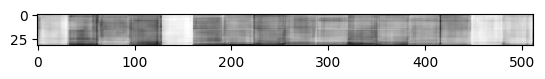

tensor([[0.7532],
        [0.9757],
        [0.9838],
        [0.9867],
        [0.8053],
        [0.9443],
        [0.9330],
        [0.9921],
        [0.9423],
        [0.9267],
        [0.9007],
        [0.9663],
        [0.2193],
        [0.8182],
        [0.9925],
        [0.8798],
        [0.4108],
        [0.3918],
        [0.9979],
        [0.9964],
        [0.9868],
        [0.9947],
        [0.8998],
        [0.9737],
        [0.9934],
        [0.9540],
        [0.9932],
        [0.9365],
        [1.0000],
        [0.9740],
        [0.5708],
        [0.9939]], grad_fn=<SigmoidBackward0>)
tensor([[0.8153],
        [0.9824],
        [0.9968],
        [0.9984],
        [0.7348],
        [0.9738],
        [0.9997],
        [0.9882],
        [0.9130],
        [0.9379],
        [1.0000],
        [0.9951],
        [0.9475],
        [0.9930],
        [0.6510],
        [0.3731],
        [0.9745],
        [0.9864],
        [0.5828],
        [0.0702],
        [0.8855],
        [0.9599],

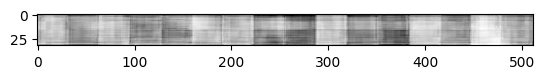

tensor([[1.9801e-02],
        [2.2095e-01],
        [9.7230e-01],
        [7.7369e-02],
        [9.0254e-01],
        [5.1837e-01],
        [4.4476e-01],
        [2.8112e-01],
        [9.2479e-01],
        [1.6926e-02],
        [4.1574e-02],
        [3.1156e-03],
        [8.7599e-01],
        [9.9844e-01],
        [1.1530e-04],
        [3.6026e-03],
        [7.3997e-01],
        [5.6390e-01],
        [6.5763e-01],
        [9.2925e-01],
        [8.7072e-01],
        [3.6755e-01],
        [1.4539e-01],
        [2.1851e-01],
        [3.3802e-01],
        [7.3121e-01],
        [1.3897e-01],
        [1.2861e-01],
        [8.8334e-01],
        [9.0644e-01],
        [4.5098e-01],
        [8.6123e-01]], grad_fn=<SigmoidBackward0>)
tensor([[0.1391],
        [0.4927],
        [0.9942],
        [0.1393],
        [0.1704],
        [0.7404],
        [0.0953],
        [0.9955],
        [0.6314],
        [0.1637],
        [0.6024],
        [0.0854],
        [0.4421],
        [0.8963],
        [0.0477

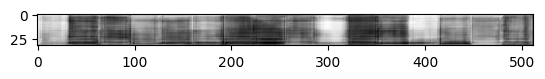

tensor([[0.9275],
        [0.7214],
        [0.4766],
        [0.5349],
        [0.8328],
        [0.8496],
        [0.4127],
        [0.7507],
        [0.7250],
        [0.9459],
        [0.7304],
        [0.8954],
        [0.7219],
        [0.6210],
        [0.6578],
        [0.6543],
        [0.9644],
        [0.2529],
        [0.6510],
        [0.7048],
        [0.7332],
        [0.0523],
        [0.8056],
        [0.8899],
        [0.6161],
        [0.7855],
        [0.9923],
        [0.3434],
        [0.9084],
        [0.2101],
        [0.9284],
        [0.8402]], grad_fn=<SigmoidBackward0>)
tensor([[0.6888],
        [0.8032],
        [0.9048],
        [0.9932],
        [0.7209],
        [0.5467],
        [0.4230],
        [0.9123],
        [0.8487],
        [0.9113],
        [0.9993],
        [0.9721],
        [0.3874],
        [0.3681],
        [0.7473],
        [0.9645],
        [0.9537],
        [0.6955],
        [0.4713],
        [0.7466],
        [0.7503],
        [0.9709],

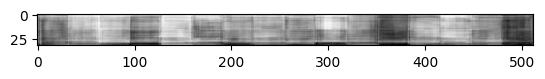

tensor([[0.4352],
        [0.4071],
        [0.4007],
        [0.0037]], grad_fn=<SigmoidBackward0>)
tensor([[0.1902],
        [0.3510],
        [0.3920],
        [0.3726]], grad_fn=<SigmoidBackward0>)
tensor(3)
tensor(0.5341, grad_fn=<BinaryCrossEntropyBackward0>)
tensor([[0.7960],
        [0.9163],
        [0.6490],
        [0.2579]], grad_fn=<SigmoidBackward0>)
Epoch 0:
	Generator and encoder train loss: 1.242973580956459
	Discriminator train loss: 2.4057257771492004
	Generator and encoder train accuracy: 334.4471435546875
	Discriminator train accuracy: 0.375
	Generator and encoder val loss: 0.7703995108604431
	Discriminator val loss: 1.4738166332244873
	Generator and encoder val accuracy: 335.9056701660156
	Discriminator val accuracy: 0.40625


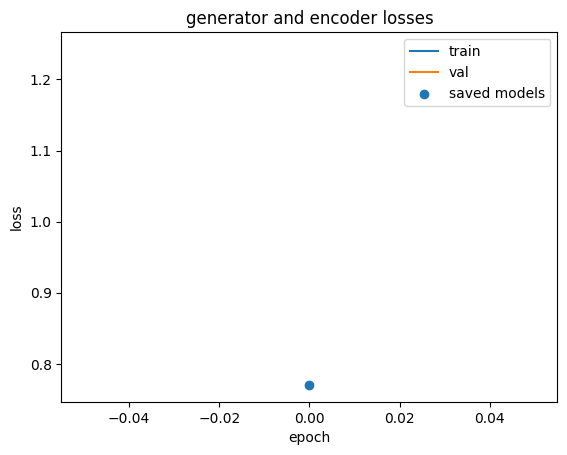

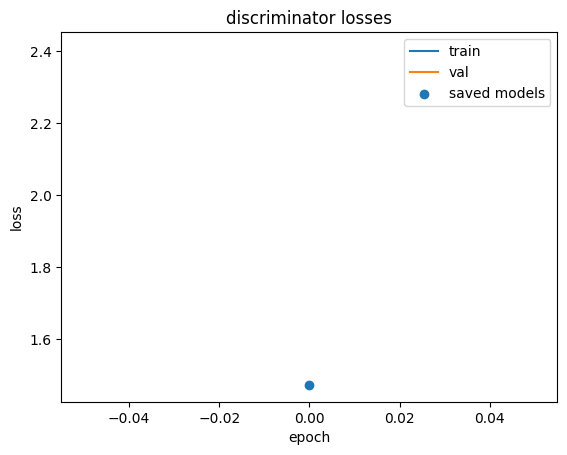

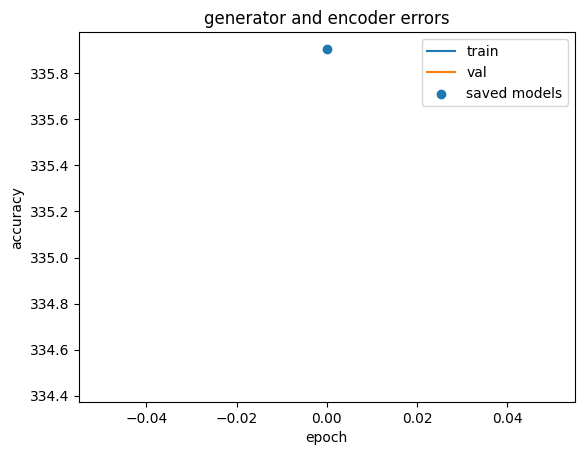

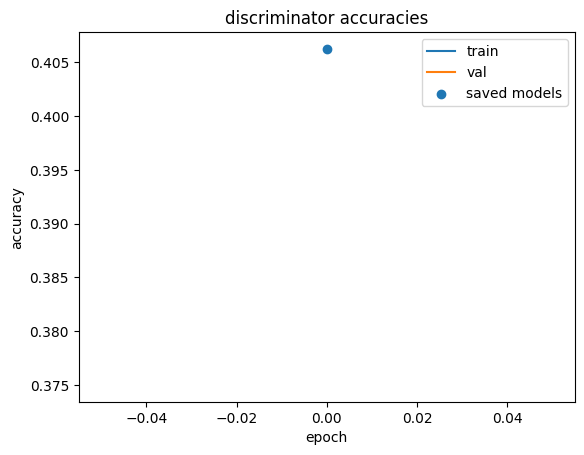

epoch 1 batch 0
real_image_batch.shape torch.Size([32, 1, 32, 512])
input_text_batch.shape torch.Size([32, 82])
torch.Size([32, 384]) torch.Size([32, 512])


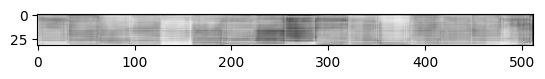

tensor([[0.5950],
        [0.3139],
        [0.4851],
        [0.4212],
        [0.9947],
        [0.7594],
        [0.6161],
        [0.7939],
        [0.3503],
        [0.2424],
        [0.7969],
        [0.8927],
        [0.3599],
        [0.8751],
        [0.5357],
        [0.1154],
        [0.3343],
        [0.1394],
        [0.7079],
        [0.4271],
        [0.6555],
        [0.1283],
        [0.8398],
        [0.8862],
        [0.7816],
        [0.2117],
        [0.2631],
        [0.6328],
        [0.6998],
        [0.9815],
        [0.6728],
        [0.1994]], grad_fn=<SigmoidBackward0>)
tensor([[0.9601],
        [0.7653],
        [0.8068],
        [0.8462],
        [0.9245],
        [0.6890],
        [0.8428],
        [0.5915],
        [0.7244],
        [0.3968],
        [0.9317],
        [0.6388],
        [0.9990],
        [0.9787],
        [0.9838],
        [0.4944],
        [0.4720],
        [0.9277],
        [0.8299],
        [0.4455],
        [0.9932],
        [0.3738],

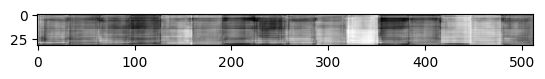

tensor([[1.4210e-02],
        [1.4203e-01],
        [1.4993e-01],
        [7.6097e-02],
        [1.3207e-03],
        [1.3545e-01],
        [3.3048e-01],
        [5.3942e-01],
        [7.0511e-02],
        [1.1966e-01],
        [1.3273e-02],
        [8.2563e-02],
        [3.0832e-01],
        [4.5537e-02],
        [4.2901e-02],
        [9.2280e-03],
        [1.1600e-01],
        [8.2607e-02],
        [6.7000e-02],
        [7.8718e-01],
        [4.1488e-02],
        [8.9296e-03],
        [1.8550e-01],
        [1.5270e-01],
        [5.3601e-02],
        [4.2091e-02],
        [1.6855e-01],
        [4.1650e-02],
        [3.0265e-02],
        [1.9237e-01],
        [4.7922e-01],
        [1.2014e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.0622],
        [0.5999],
        [0.0849],
        [0.6026],
        [0.0133],
        [0.7446],
        [0.2846],
        [0.5560],
        [0.0193],
        [0.0066],
        [0.1538],
        [0.9074],
        [0.2144],
        [0.1468],
        [0.3639

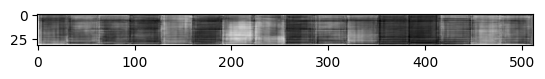

tensor([[0.9080],
        [0.1276],
        [0.5843],
        [0.4646],
        [0.9188],
        [0.5638],
        [0.9578],
        [0.9182],
        [0.7018],
        [0.7340],
        [0.8715],
        [0.7044],
        [0.2979],
        [0.5736],
        [0.9481],
        [0.7933],
        [0.4099],
        [0.5090],
        [0.1317],
        [0.7970],
        [0.5290],
        [0.5464],
        [0.8413],
        [0.7846],
        [0.3407],
        [0.2296],
        [0.7886],
        [0.5982],
        [0.7351],
        [0.8015],
        [0.0951],
        [0.7149]], grad_fn=<SigmoidBackward0>)
tensor([[0.9432],
        [0.8548],
        [0.8429],
        [0.8845],
        [0.6071],
        [0.7746],
        [0.9521],
        [0.9570],
        [0.8447],
        [0.9970],
        [0.9390],
        [0.8062],
        [0.9041],
        [0.8264],
        [0.9228],
        [0.9242],
        [0.3445],
        [0.9776],
        [0.8813],
        [0.7438],
        [0.8001],
        [0.9906],

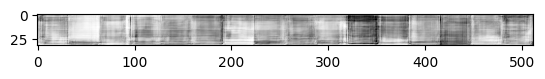

tensor([[0.0470],
        [0.0356],
        [0.2585],
        [0.1658]], grad_fn=<SigmoidBackward0>)
tensor([[0.4559],
        [0.2454],
        [0.2930],
        [0.2911]], grad_fn=<SigmoidBackward0>)
tensor(3)
tensor(0.5639, grad_fn=<BinaryCrossEntropyBackward0>)
tensor([[0.6499],
        [0.3045],
        [0.8737],
        [0.6198]], grad_fn=<SigmoidBackward0>)
Epoch 1:
	Generator and encoder train loss: 1.72364841401577
	Discriminator train loss: 1.5453334748744965
	Generator and encoder train accuracy: 333.2817077636719
	Discriminator train accuracy: 0.46875
	Generator and encoder val loss: 0.9353300333023071
	Discriminator val loss: 1.2316282987594604
	Generator and encoder val accuracy: 351.64276123046875
	Discriminator val accuracy: 0.40625


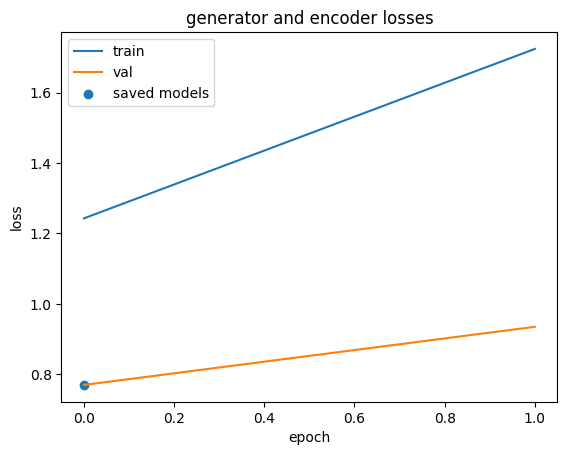

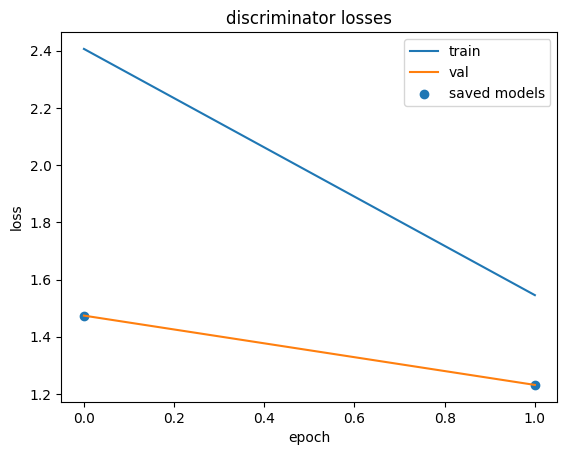

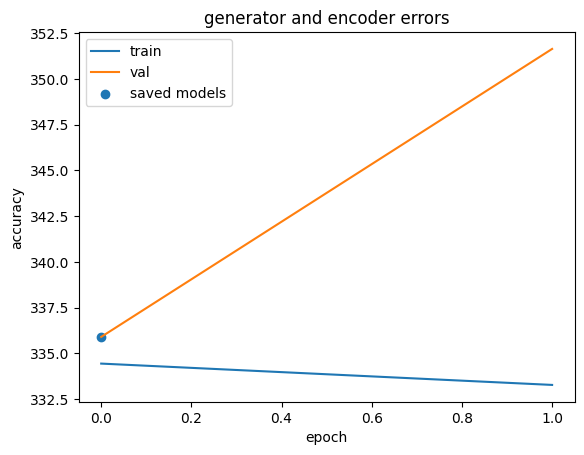

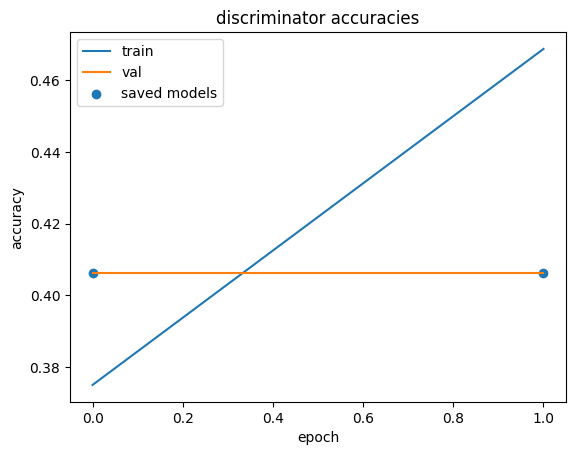

epoch 2 batch 0
real_image_batch.shape torch.Size([32, 1, 32, 512])
input_text_batch.shape torch.Size([32, 82])
torch.Size([32, 384]) torch.Size([32, 512])


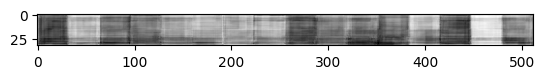

tensor([[0.7069],
        [0.7398],
        [0.3681],
        [0.4030],
        [0.4328],
        [0.6608],
        [0.5810],
        [0.8839],
        [0.2603],
        [0.8631],
        [0.4162],
        [0.7099],
        [0.5253],
        [0.2430],
        [0.2877],
        [0.2685],
        [0.5909],
        [0.4203],
        [0.7320],
        [0.7201],
        [0.8084],
        [0.3672],
        [0.3091],
        [0.7230],
        [0.1019],
        [0.5319],
        [0.4481],
        [0.7236],
        [0.7204],
        [0.7742],
        [0.4208],
        [0.2015]], grad_fn=<SigmoidBackward0>)
tensor([[0.7380],
        [0.5970],
        [0.8816],
        [0.9748],
        [0.8964],
        [0.9934],
        [0.8548],
        [0.7797],
        [0.6750],
        [0.7975],
        [0.9381],
        [0.7521],
        [0.9891],
        [0.5071],
        [0.7929],
        [0.9432],
        [0.9904],
        [0.9476],
        [0.9580],
        [0.7339],
        [0.9100],
        [0.9578],

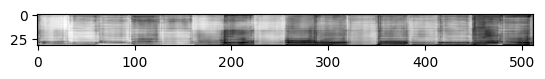

tensor([[5.1787e-02],
        [2.3413e-01],
        [7.1091e-02],
        [3.3709e-02],
        [1.2581e-01],
        [1.2061e-01],
        [1.0557e-01],
        [5.3896e-02],
        [2.3449e-02],
        [3.9280e-03],
        [2.5783e-01],
        [8.8982e-03],
        [7.3681e-02],
        [1.5121e-02],
        [7.0510e-05],
        [1.3743e-01],
        [1.2248e-01],
        [7.1732e-02],
        [8.3953e-02],
        [8.0912e-02],
        [1.7625e-01],
        [8.1235e-02],
        [1.5807e-01],
        [9.6833e-02],
        [1.6355e-01],
        [1.2326e-01],
        [5.2886e-02],
        [2.7983e-02],
        [1.4945e-01],
        [7.0491e-03],
        [2.8329e-01],
        [2.0439e-02]], grad_fn=<SigmoidBackward0>)
tensor([[0.4992],
        [0.5704],
        [0.6713],
        [0.4223],
        [0.0879],
        [0.6819],
        [0.4226],
        [0.1930],
        [0.4765],
        [0.0191],
        [0.3193],
        [0.5418],
        [0.5178],
        [0.3382],
        [0.1428

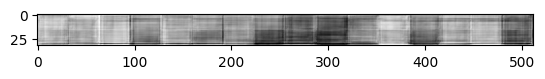

tensor([[0.7716],
        [0.9589],
        [0.1681],
        [0.2984],
        [0.7403],
        [0.8039],
        [0.4721],
        [0.8698],
        [0.5222],
        [0.4038],
        [0.4375],
        [0.0882],
        [0.3670],
        [0.6885],
        [0.7441],
        [0.4794],
        [0.6999],
        [0.2228],
        [0.1755],
        [0.9370],
        [0.8689],
        [0.3610],
        [0.5189],
        [0.8275],
        [0.5140],
        [0.8963],
        [0.1333],
        [0.1281],
        [0.1483],
        [0.4709],
        [0.7459],
        [0.3793]], grad_fn=<SigmoidBackward0>)
tensor([[0.9089],
        [0.9609],
        [0.9506],
        [0.9330],
        [0.8506],
        [0.9920],
        [0.9256],
        [0.7324],
        [0.9739],
        [0.9690],
        [0.8433],
        [0.8359],
        [0.9558],
        [0.8878],
        [0.9123],
        [0.9463],
        [0.9857],
        [0.9135],
        [0.8162],
        [0.7013],
        [0.8966],
        [0.9547],

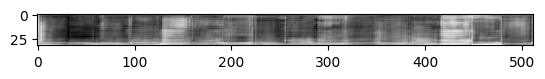

tensor([[0.0916],
        [0.0427],
        [0.0758],
        [0.0181]], grad_fn=<SigmoidBackward0>)
tensor([[0.4821],
        [0.3679],
        [0.4171],
        [0.1413]], grad_fn=<SigmoidBackward0>)
tensor(2)
tensor(0.8739, grad_fn=<BinaryCrossEntropyBackward0>)
tensor([[0.4131],
        [0.5595],
        [0.7349],
        [0.1774]], grad_fn=<SigmoidBackward0>)
Epoch 2:
	Generator and encoder train loss: 1.9640881419181824
	Discriminator train loss: 1.1596337258815765
	Generator and encoder train accuracy: 325.9200439453125
	Discriminator train accuracy: 0.5546875
	Generator and encoder val loss: 1.1375261545181274
	Discriminator val loss: 0.9265031218528748
	Generator and encoder val accuracy: 336.77947998046875
	Discriminator val accuracy: 0.4375


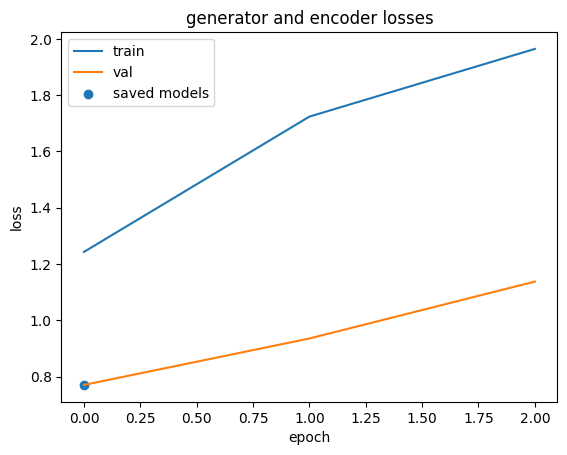

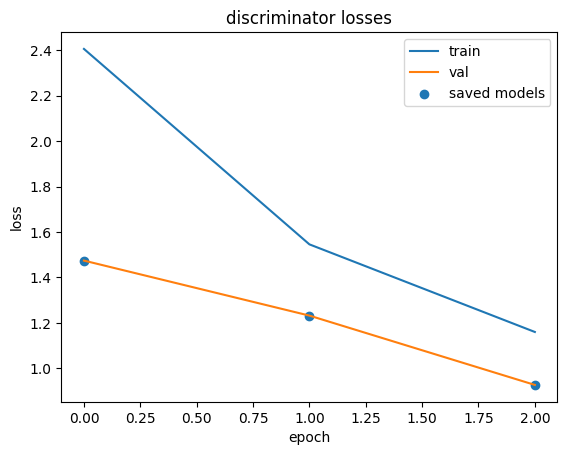

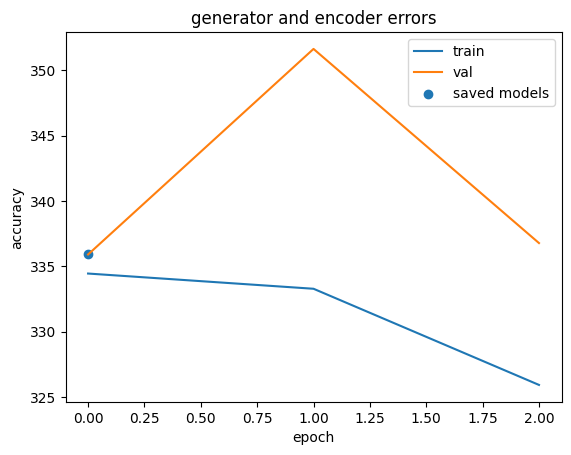

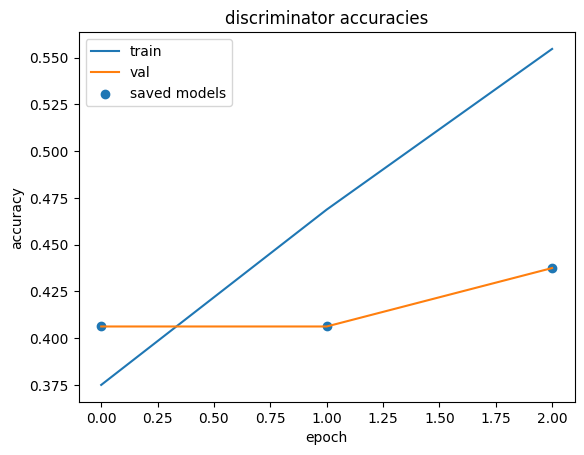

epoch 3 batch 0
real_image_batch.shape torch.Size([32, 1, 32, 512])
input_text_batch.shape torch.Size([32, 82])
torch.Size([32, 384]) torch.Size([32, 512])


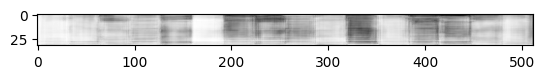

tensor([[0.1447],
        [0.8103],
        [0.6679],
        [0.6108],
        [0.1805],
        [0.5789],
        [0.2198],
        [0.4507],
        [0.6290],
        [0.4144],
        [0.0853],
        [0.4345],
        [0.5550],
        [0.5360],
        [0.6354],
        [0.4849],
        [0.3756],
        [0.4873],
        [0.6230],
        [0.2514],
        [0.7549],
        [0.1853],
        [0.3260],
        [0.3351],
        [0.1719],
        [0.1987],
        [0.6583],
        [0.3733],
        [0.0852],
        [0.8216],
        [0.0472],
        [0.5621]], grad_fn=<SigmoidBackward0>)
tensor([[0.9695],
        [0.9710],
        [0.7302],
        [0.9504],
        [0.9517],
        [0.9686],
        [0.8555],
        [0.9053],
        [0.9965],
        [0.9493],
        [0.9273],
        [0.8992],
        [0.6777],
        [0.9652],
        [0.8271],
        [0.9774],
        [0.9909],
        [0.9883],
        [0.7397],
        [0.9805],
        [0.9941],
        [0.9859],

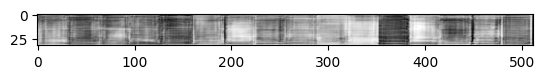

tensor([[7.4159e-02],
        [5.2298e-02],
        [2.3767e-03],
        [8.9613e-02],
        [3.5456e-02],
        [1.0714e-01],
        [1.5177e-01],
        [3.6230e-02],
        [2.8003e-01],
        [1.0378e-01],
        [6.2541e-02],
        [1.2646e-02],
        [2.6839e-02],
        [4.5319e-02],
        [5.1042e-02],
        [3.7108e-02],
        [6.2098e-03],
        [3.7526e-03],
        [4.6015e-02],
        [7.1924e-02],
        [3.2939e-04],
        [9.6411e-02],
        [2.5995e-02],
        [2.0871e-02],
        [2.2154e-01],
        [4.0087e-05],
        [5.4284e-02],
        [4.0627e-02],
        [1.0230e-01],
        [2.6801e-02],
        [7.3418e-02],
        [7.4916e-02]], grad_fn=<SigmoidBackward0>)
tensor([[0.5329],
        [0.6920],
        [0.4459],
        [0.5504],
        [0.4978],
        [0.7964],
        [0.1911],
        [0.3461],
        [0.5808],
        [0.4712],
        [0.4141],
        [0.7243],
        [0.4434],
        [0.5579],
        [0.2557

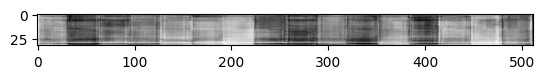

tensor([[0.0359],
        [0.1457],
        [0.5015],
        [0.4101],
        [0.5270],
        [0.2330],
        [0.4152],
        [0.5133],
        [0.6516],
        [0.1720],
        [0.8940],
        [0.5488],
        [0.4985],
        [0.5461],
        [0.1025],
        [0.2221],
        [0.5053],
        [0.1037],
        [0.6237],
        [0.7129],
        [0.3718],
        [0.1929],
        [0.2973],
        [0.4160],
        [0.2415],
        [0.1539],
        [0.2975],
        [0.5382],
        [0.2706],
        [0.9401],
        [0.4384],
        [0.3013]], grad_fn=<SigmoidBackward0>)
tensor([[0.9893],
        [0.9477],
        [0.8967],
        [0.9133],
        [0.7715],
        [0.9886],
        [0.9816],
        [0.9628],
        [0.9647],
        [0.7863],
        [0.9392],
        [0.9710],
        [0.8752],
        [0.9040],
        [0.9851],
        [0.9595],
        [0.9619],
        [0.9825],
        [0.9437],
        [0.7893],
        [0.7982],
        [0.9970],

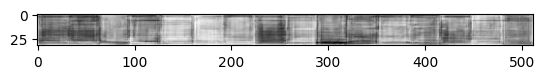

tensor([[0.0296],
        [0.1720],
        [0.0155],
        [0.0081]], grad_fn=<SigmoidBackward0>)
tensor([[0.5469],
        [0.5099],
        [0.6015],
        [0.1214]], grad_fn=<SigmoidBackward0>)
tensor(1)
tensor(1.1726, grad_fn=<BinaryCrossEntropyBackward0>)
tensor([[0.2337],
        [0.7582],
        [0.2231],
        [0.2265]], grad_fn=<SigmoidBackward0>)
Epoch 3:
	Generator and encoder train loss: 2.3588583767414093
	Discriminator train loss: 0.9231447726488113
	Generator and encoder train accuracy: 326.9892272949219
	Discriminator train accuracy: 0.6015625
	Generator and encoder val loss: 1.0985208749771118
	Discriminator val loss: 0.6746706962585449
	Generator and encoder val accuracy: 329.6754455566406
	Discriminator val accuracy: 0.53125


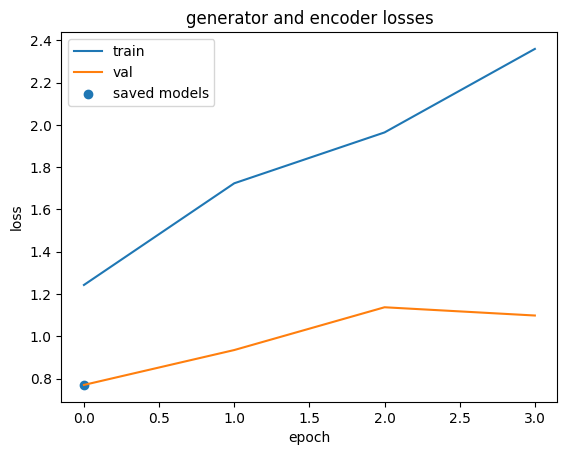

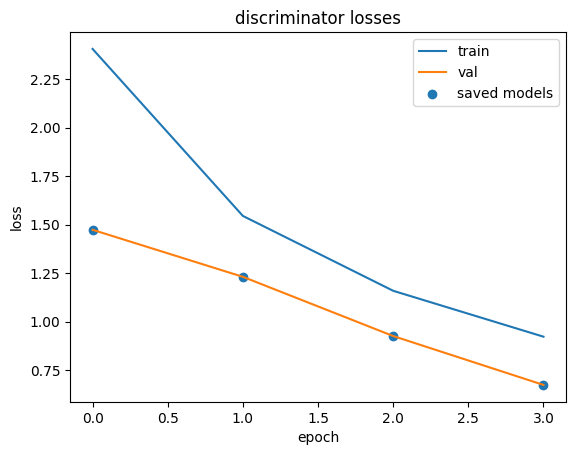

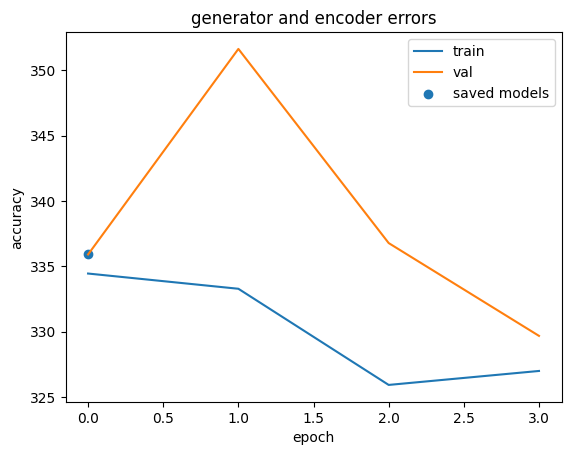

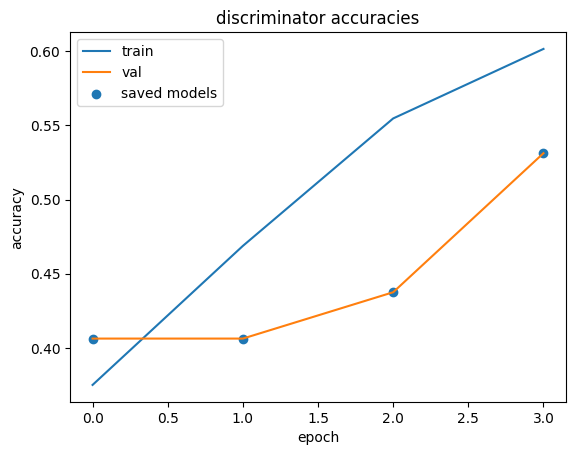

epoch 4 batch 0
real_image_batch.shape torch.Size([32, 1, 32, 512])
input_text_batch.shape torch.Size([32, 82])
torch.Size([32, 384]) torch.Size([32, 512])


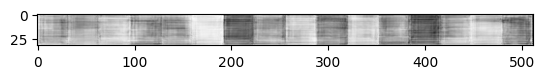

tensor([[0.5074],
        [0.2577],
        [0.1331],
        [0.4930],
        [0.2141],
        [0.4026],
        [0.4692],
        [0.3637],
        [0.5959],
        [0.7098],
        [0.4431],
        [0.7539],
        [0.0675],
        [0.3711],
        [0.1111],
        [0.2727],
        [0.0860],
        [0.6983],
        [0.0563],
        [0.5369],
        [0.2320],
        [0.3166],
        [0.5549],
        [0.6298],
        [0.7614],
        [0.3437],
        [0.2897],
        [0.2619],
        [0.0273],
        [0.6910],
        [0.4890],
        [0.7356]], grad_fn=<SigmoidBackward0>)
tensor([[0.9880],
        [0.9157],
        [0.9906],
        [0.9477],
        [0.9795],
        [0.9874],
        [0.8945],
        [0.7135],
        [0.9563],
        [0.9580],
        [0.9550],
        [0.9279],
        [0.8257],
        [0.9092],
        [0.9807],
        [0.9902],
        [0.9479],
        [0.9212],
        [0.8908],
        [0.9888],
        [0.9791],
        [0.9891],

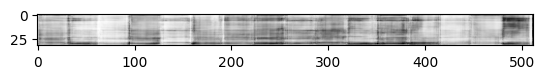

tensor([[0.0069],
        [0.0302],
        [0.0911],
        [0.0714],
        [0.0741],
        [0.0114],
        [0.0125],
        [0.0345],
        [0.0873],
        [0.1919],
        [0.0421],
        [0.0829],
        [0.0404],
        [0.0061],
        [0.0009],
        [0.0528],
        [0.0021],
        [0.1755],
        [0.0277],
        [0.0313],
        [0.0036],
        [0.0042],
        [0.0363],
        [0.0296],
        [0.0313],
        [0.0115],
        [0.0189],
        [0.0137],
        [0.0309],
        [0.0328],
        [0.0134],
        [0.0310]], grad_fn=<SigmoidBackward0>)
tensor([[0.4087],
        [0.6563],
        [0.7360],
        [0.3613],
        [0.5325],
        [0.4942],
        [0.5428],
        [0.7444],
        [0.2592],
        [0.5020],
        [0.7906],
        [0.3809],
        [0.3304],
        [0.5002],
        [0.5826],
        [0.2632],
        [0.2361],
        [0.4222],
        [0.1400],
        [0.7240],
        [0.4733],
        [0.7475],

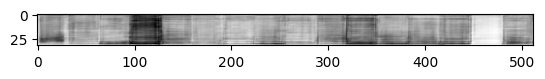

tensor([[0.4546],
        [0.7682],
        [0.7572],
        [0.0627],
        [0.2037],
        [0.3184],
        [0.3606],
        [0.7163],
        [0.1832],
        [0.3993],
        [0.9897],
        [0.1672],
        [0.0400],
        [0.4352],
        [0.2032],
        [0.2891],
        [0.1981],
        [0.8620],
        [0.0885],
        [0.5164],
        [0.2681],
        [0.3131],
        [0.0804],
        [0.1884],
        [0.3460],
        [0.1953],
        [0.2529],
        [0.1167],
        [0.5293],
        [0.3188],
        [0.0448],
        [0.2909]], grad_fn=<SigmoidBackward0>)
tensor([[0.9930],
        [0.8848],
        [0.9316],
        [0.9628],
        [0.9773],
        [0.9260],
        [0.9708],
        [0.9925],
        [0.9873],
        [0.9987],
        [0.9481],
        [0.7918],
        [0.8866],
        [0.9644],
        [0.9502],
        [0.9443],
        [0.9554],
        [0.8357],
        [0.9414],
        [0.9721],
        [0.9985],
        [0.9923],

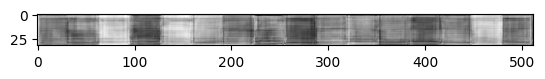

tensor([[0.1197],
        [0.0157],
        [0.0792],
        [0.0260]], grad_fn=<SigmoidBackward0>)
tensor([[0.0437],
        [0.6880],
        [0.6444],
        [0.5906]], grad_fn=<SigmoidBackward0>)
tensor(1)
tensor(0.8232, grad_fn=<BinaryCrossEntropyBackward0>)
tensor([[0.5093],
        [0.4600],
        [0.4369],
        [0.3595]], grad_fn=<SigmoidBackward0>)
Epoch 4:
	Generator and encoder train loss: 2.390209674835205
	Discriminator train loss: 0.858169287443161
	Generator and encoder train accuracy: 332.5412292480469
	Discriminator train accuracy: 0.65625
	Generator and encoder val loss: 1.278469443321228
	Discriminator val loss: 0.4487258493900299
	Generator and encoder val accuracy: 339.25469970703125
	Discriminator val accuracy: 0.59375


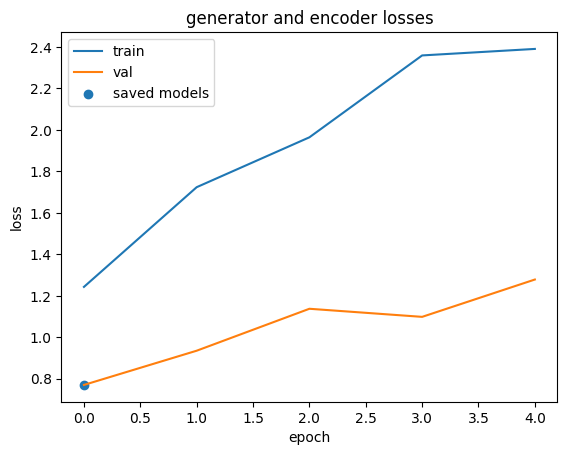

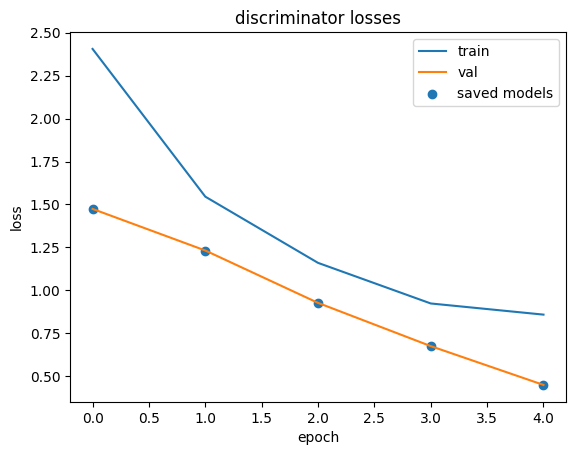

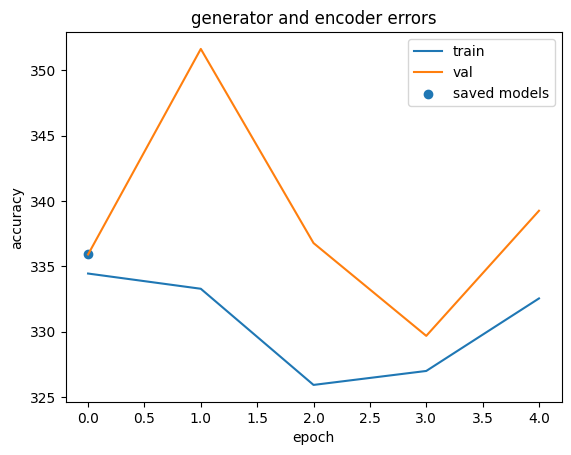

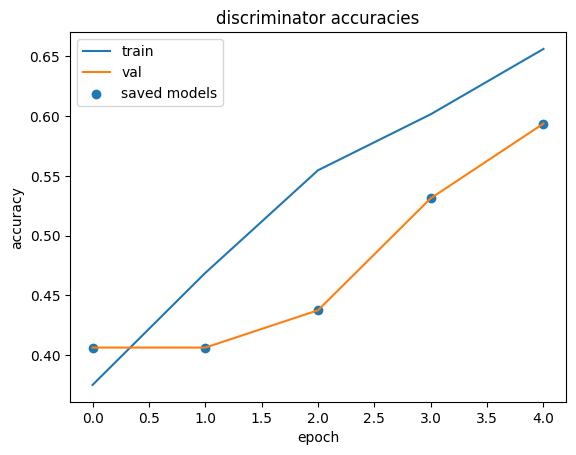

epoch 5 batch 0
real_image_batch.shape torch.Size([32, 1, 32, 512])
input_text_batch.shape torch.Size([32, 82])
torch.Size([32, 384]) torch.Size([32, 512])


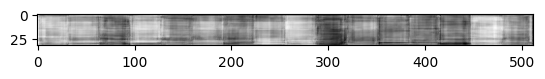

tensor([[0.0969],
        [0.1041],
        [0.5295],
        [0.4278],
        [0.2235],
        [0.5717],
        [0.6765],
        [0.4448],
        [0.1631],
        [0.2494],
        [0.4184],
        [0.5219],
        [0.2789],
        [0.1205],
        [0.3121],
        [0.4317],
        [0.3086],
        [0.0911],
        [0.0714],
        [0.1486],
        [0.3534],
        [0.6643],
        [0.0405],
        [0.1699],
        [0.4092],
        [0.2383],
        [0.4550],
        [0.3679],
        [0.2246],
        [0.3510],
        [0.3242],
        [0.8044]], grad_fn=<SigmoidBackward0>)
tensor([[0.9861],
        [0.9937],
        [0.9099],
        [0.8767],
        [0.9474],
        [0.9797],
        [0.9688],
        [0.9380],
        [0.9805],
        [0.8680],
        [0.9489],
        [0.9938],
        [0.8605],
        [0.9846],
        [0.9615],
        [0.9504],
        [0.9804],
        [0.9870],
        [0.9810],
        [0.9913],
        [0.9377],
        [0.9616],

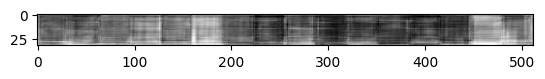

tensor([[0.0295],
        [0.0030],
        [0.0161],
        [0.0320],
        [0.0692],
        [0.0085],
        [0.0028],
        [0.0333],
        [0.0465],
        [0.0298],
        [0.0087],
        [0.0053],
        [0.0115],
        [0.0367],
        [0.0640],
        [0.0229],
        [0.0390],
        [0.0150],
        [0.0183],
        [0.0013],
        [0.0015],
        [0.0343],
        [0.0192],
        [0.0327],
        [0.0157],
        [0.0020],
        [0.0236],
        [0.0292],
        [0.0015],
        [0.0111],
        [0.0212],
        [0.0150]], grad_fn=<SigmoidBackward0>)
tensor([[0.3509],
        [0.6805],
        [0.4737],
        [0.1903],
        [0.6819],
        [0.5738],
        [0.4813],
        [0.6067],
        [0.3696],
        [0.4250],
        [0.8251],
        [0.6919],
        [0.5563],
        [0.6615],
        [0.1843],
        [0.2263],
        [0.6107],
        [0.8540],
        [0.8271],
        [0.5514],
        [0.5498],
        [0.5805],

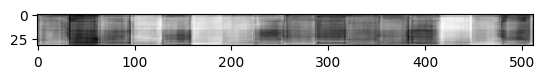

tensor([[0.3872],
        [0.1709],
        [0.2742],
        [0.4865],
        [0.4087],
        [0.4905],
        [0.1551],
        [0.0213],
        [0.1214],
        [0.1829],
        [0.2937],
        [0.2836],
        [0.1327],
        [0.4990],
        [0.1033],
        [0.9168],
        [0.4559],
        [0.0112],
        [0.1334],
        [0.2098],
        [0.2256],
        [0.1064],
        [0.2879],
        [0.3207],
        [0.0115],
        [0.7119],
        [0.3516],
        [0.1619],
        [0.1406],
        [0.8949],
        [0.3360],
        [0.3067]], grad_fn=<SigmoidBackward0>)
tensor([[0.9860],
        [0.9493],
        [0.9744],
        [0.9975],
        [0.9252],
        [0.9436],
        [0.9815],
        [0.9493],
        [0.9222],
        [0.9655],
        [0.9728],
        [0.9978],
        [0.9900],
        [0.9720],
        [0.9930],
        [0.9152],
        [0.9881],
        [0.9952],
        [0.9601],
        [0.8890],
        [0.9254],
        [0.9797],

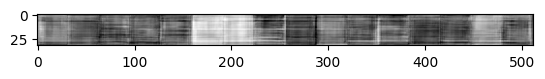

tensor([[0.0237],
        [0.0467],
        [0.0063],
        [0.0182]], grad_fn=<SigmoidBackward0>)
tensor([[0.9245],
        [0.5991],
        [0.9067],
        [0.6783]], grad_fn=<SigmoidBackward0>)
tensor(0)
tensor(1.4958, grad_fn=<BinaryCrossEntropyBackward0>)
tensor([[0.1677],
        [0.3589],
        [0.2383],
        [0.1672]], grad_fn=<SigmoidBackward0>)
Epoch 5:
	Generator and encoder train loss: 2.8212892413139343
	Discriminator train loss: 0.5438229441642761
	Generator and encoder train accuracy: 328.80523681640625
	Discriminator train accuracy: 0.69921875
	Generator and encoder val loss: 1.6563243865966797
	Discriminator val loss: 0.3102911114692688
	Generator and encoder val accuracy: 329.2645263671875
	Discriminator val accuracy: 0.625


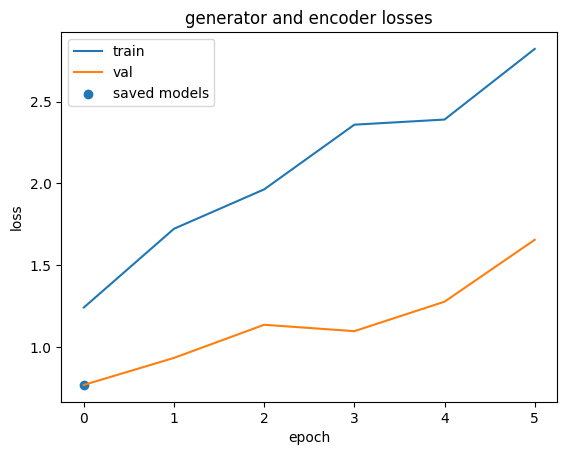

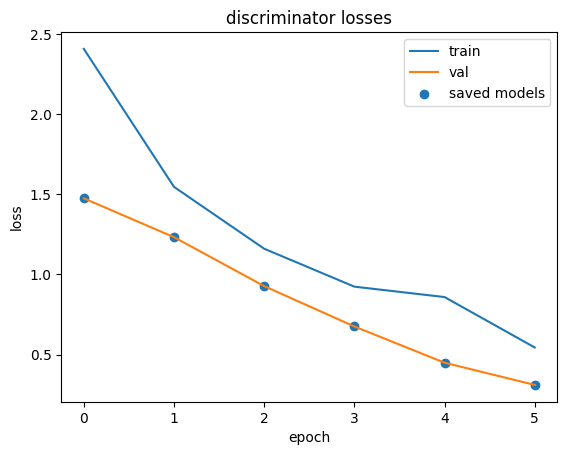

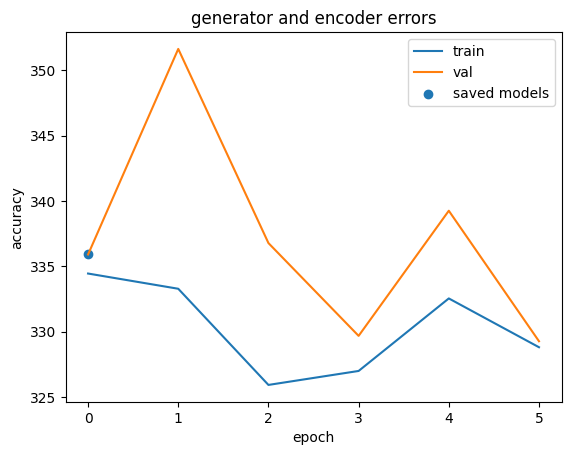

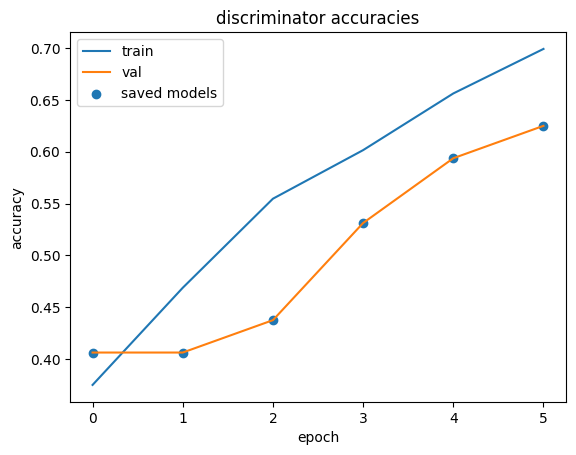

epoch 6 batch 0
real_image_batch.shape torch.Size([32, 1, 32, 512])
input_text_batch.shape torch.Size([32, 82])
torch.Size([32, 384]) torch.Size([32, 512])


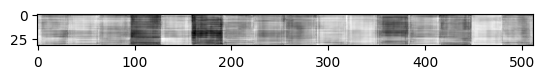

tensor([[0.3170],
        [0.1594],
        [0.6325],
        [0.0373],
        [0.3286],
        [0.1264],
        [0.1116],
        [0.4021],
        [0.1474],
        [0.1477],
        [0.3927],
        [0.7282],
        [0.2823],
        [0.1310],
        [0.3726],
        [0.1535],
        [0.2710],
        [0.3428],
        [0.0715],
        [0.4608],
        [0.1186],
        [0.1089],
        [0.0347],
        [0.2763],
        [0.3498],
        [0.2935],
        [0.0462],
        [0.0477],
        [0.2201],
        [0.0526],
        [0.0644],
        [0.1589]], grad_fn=<SigmoidBackward0>)
tensor([[0.9427],
        [0.9762],
        [0.9714],
        [0.9480],
        [0.9796],
        [0.9323],
        [0.9777],
        [0.9684],
        [0.9989],
        [0.9971],
        [0.9785],
        [0.9325],
        [0.9639],
        [0.9611],
        [0.9463],
        [0.9604],
        [0.9629],
        [0.9624],
        [0.8814],
        [0.9870],
        [0.9922],
        [0.9624],

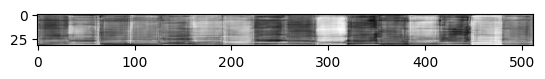

tensor([[5.5360e-02],
        [2.4834e-03],
        [3.2252e-02],
        [1.9243e-01],
        [5.8153e-02],
        [3.6889e-02],
        [2.9819e-04],
        [1.6004e-02],
        [3.2490e-02],
        [8.7794e-03],
        [8.5682e-02],
        [4.8999e-02],
        [8.8101e-02],
        [1.2923e-03],
        [1.5301e-03],
        [4.5270e-02],
        [1.6532e-04],
        [5.3041e-03],
        [2.0655e-02],
        [2.1636e-02],
        [1.8823e-02],
        [5.2844e-03],
        [1.5281e-02],
        [1.9154e-02],
        [1.3847e-02],
        [2.8417e-02],
        [8.7037e-04],
        [8.2208e-02],
        [5.9851e-03],
        [2.2162e-03],
        [2.0172e-03],
        [4.0560e-02]], grad_fn=<SigmoidBackward0>)
tensor([[0.8330],
        [0.6491],
        [0.3084],
        [0.9400],
        [0.5173],
        [0.5067],
        [0.8713],
        [0.2875],
        [0.6524],
        [0.6055],
        [0.8943],
        [0.7851],
        [0.7616],
        [0.9070],
        [0.3003

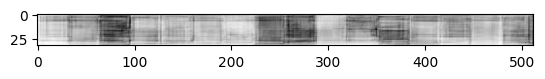

tensor([[0.0579],
        [0.5582],
        [0.1114],
        [0.1460],
        [0.0523],
        [0.0578],
        [0.2773],
        [0.2853],
        [0.5634],
        [0.1674],
        [0.1793],
        [0.2478],
        [0.1843],
        [0.4967],
        [0.1073],
        [0.5063],
        [0.2895],
        [0.2954],
        [0.2420],
        [0.1513],
        [0.5936],
        [0.2069],
        [0.2979],
        [0.1991],
        [0.2805],
        [0.2680],
        [0.0745],
        [0.0242],
        [0.3638],
        [0.4165],
        [0.0307],
        [0.5662]], grad_fn=<SigmoidBackward0>)
tensor([[0.9617],
        [0.9887],
        [0.9542],
        [0.9058],
        [0.9554],
        [0.9780],
        [0.9059],
        [0.9942],
        [0.9787],
        [0.9880],
        [0.9459],
        [0.9866],
        [0.9706],
        [0.9787],
        [0.9815],
        [0.9918],
        [0.9965],
        [0.9953],
        [0.8927],
        [0.9259],
        [0.9724],
        [0.9797],

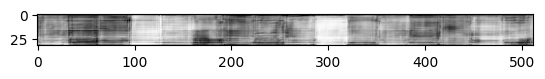

tensor([[0.0141],
        [0.0198],
        [0.0037],
        [0.0074]], grad_fn=<SigmoidBackward0>)
tensor([[0.8030],
        [0.3135],
        [0.2351],
        [0.8806]], grad_fn=<SigmoidBackward0>)
tensor(0)
tensor(2.0980, grad_fn=<BinaryCrossEntropyBackward0>)
tensor([[0.1835],
        [0.2006],
        [0.0468],
        [0.1217]], grad_fn=<SigmoidBackward0>)
Epoch 6:
	Generator and encoder train loss: 3.210800379514694
	Discriminator train loss: 0.5326850935816765
	Generator and encoder train accuracy: 334.6726989746094
	Discriminator train accuracy: 0.7265625
	Generator and encoder val loss: 2.2535507678985596
	Discriminator val loss: 0.2406829297542572
	Generator and encoder val accuracy: 335.1548156738281
	Discriminator val accuracy: 0.625


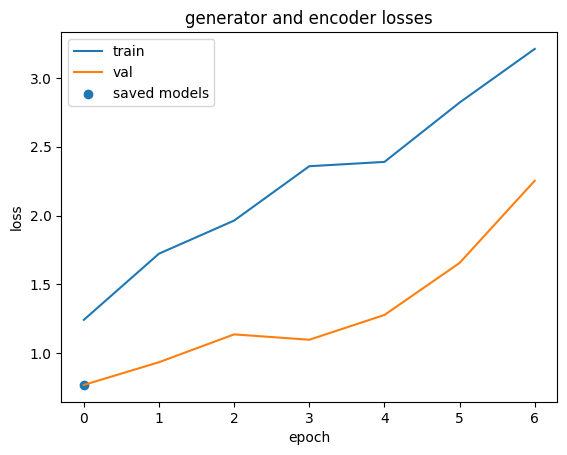

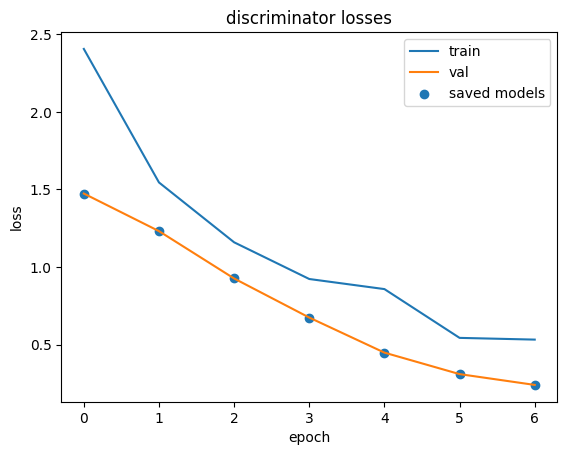

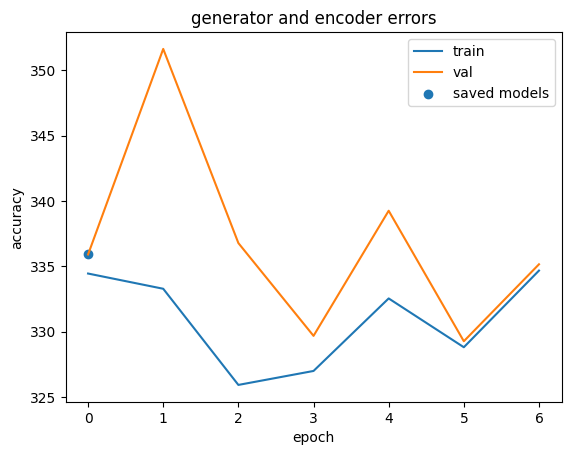

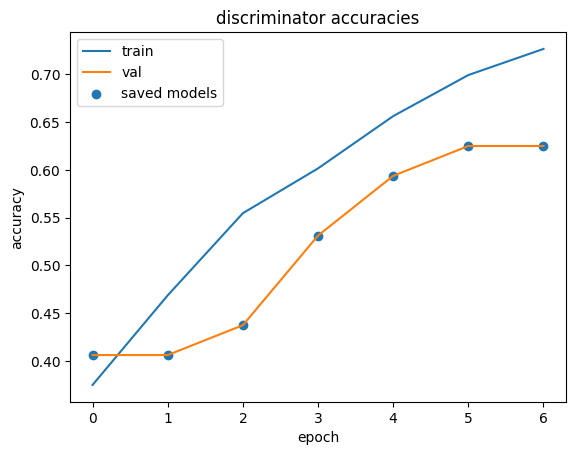

epoch 7 batch 0
real_image_batch.shape torch.Size([32, 1, 32, 512])
input_text_batch.shape torch.Size([32, 82])
torch.Size([32, 384]) torch.Size([32, 512])


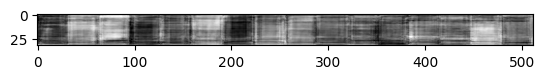

tensor([[0.1765],
        [0.2658],
        [0.4829],
        [0.1554],
        [0.2284],
        [0.2446],
        [0.0430],
        [0.0216],
        [0.0603],
        [0.1560],
        [0.0040],
        [0.0618],
        [0.0803],
        [0.0776],
        [0.2558],
        [0.0936],
        [0.2838],
        [0.0012],
        [0.1147],
        [0.0493],
        [0.0669],
        [0.1156],
        [0.1794],
        [0.0166],
        [0.1931],
        [0.1804],
        [0.1495],
        [0.1987],
        [0.2407],
        [0.0928],
        [0.0202],
        [0.1943]], grad_fn=<SigmoidBackward0>)
tensor([[0.9108],
        [0.9620],
        [0.9779],
        [0.9946],
        [0.9739],
        [0.9703],
        [0.9955],
        [0.9859],
        [0.9694],
        [0.8934],
        [0.9986],
        [0.9673],
        [0.9563],
        [0.9204],
        [0.9582],
        [0.9888],
        [0.9696],
        [0.9567],
        [0.9897],
        [0.9902],
        [0.9819],
        [0.9571],

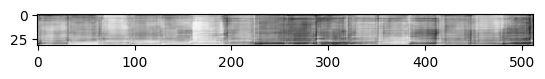

tensor([[0.0010],
        [0.0020],
        [0.0058],
        [0.0020],
        [0.0037],
        [0.0030],
        [0.0068],
        [0.0041],
        [0.0110],
        [0.0137],
        [0.0056],
        [0.0042],
        [0.0272],
        [0.0169],
        [0.0034],
        [0.0094],
        [0.0118],
        [0.0016],
        [0.0021],
        [0.0002],
        [0.0056],
        [0.0536],
        [0.0160],
        [0.0014],
        [0.0333],
        [0.0017],
        [0.0037],
        [0.0029],
        [0.0131],
        [0.0007],
        [0.0036],
        [0.0105]], grad_fn=<SigmoidBackward0>)
tensor([[0.8118],
        [0.5788],
        [0.7864],
        [0.6804],
        [0.8286],
        [0.9355],
        [0.8008],
        [0.6609],
        [0.6435],
        [0.3679],
        [0.8883],
        [0.3017],
        [0.6670],
        [0.8242],
        [0.6278],
        [0.6305],
        [0.7109],
        [0.6738],
        [0.8816],
        [0.5585],
        [0.5841],
        [0.5290],

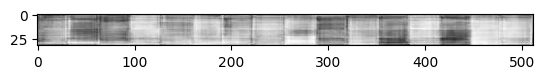

tensor([[0.0284],
        [0.1249],
        [0.0622],
        [0.3926],
        [0.1981],
        [0.3412],
        [0.0338],
        [0.0962],
        [0.7029],
        [0.0219],
        [0.1396],
        [0.0230],
        [0.1755],
        [0.0823],
        [0.1114],
        [0.7358],
        [0.1425],
        [0.5536],
        [0.0343],
        [0.2748],
        [0.0915],
        [0.3327],
        [0.0388],
        [0.1576],
        [0.0241],
        [0.1324],
        [0.2424],
        [0.0512],
        [0.1814],
        [0.4746],
        [0.0278],
        [0.2862]], grad_fn=<SigmoidBackward0>)
tensor([[0.9938],
        [0.9447],
        [0.9931],
        [0.9818],
        [0.9923],
        [0.9987],
        [0.9974],
        [0.9637],
        [0.9752],
        [0.9823],
        [0.9884],
        [0.9817],
        [0.9801],
        [0.9357],
        [0.9673],
        [0.9722],
        [0.9928],
        [0.9974],
        [0.9689],
        [0.9923],
        [0.9846],
        [0.9749],

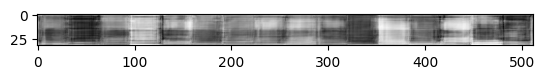

tensor([[0.0129],
        [0.0087],
        [0.0182],
        [0.0103]], grad_fn=<SigmoidBackward0>)
tensor([[0.9548],
        [0.8945],
        [0.5654],
        [0.7734]], grad_fn=<SigmoidBackward0>)
tensor(0)
tensor(1.7841, grad_fn=<BinaryCrossEntropyBackward0>)
tensor([[0.1124],
        [0.1467],
        [0.1973],
        [0.2292]], grad_fn=<SigmoidBackward0>)
Epoch 7:
	Generator and encoder train loss: 3.6318905353546143
	Discriminator train loss: 0.3442239463329315
	Generator and encoder train accuracy: 331.6268005371094
	Discriminator train accuracy: 0.7578125
	Generator and encoder val loss: 2.862542152404785
	Discriminator val loss: 0.12439978122711182
	Generator and encoder val accuracy: 332.72161865234375
	Discriminator val accuracy: 0.625


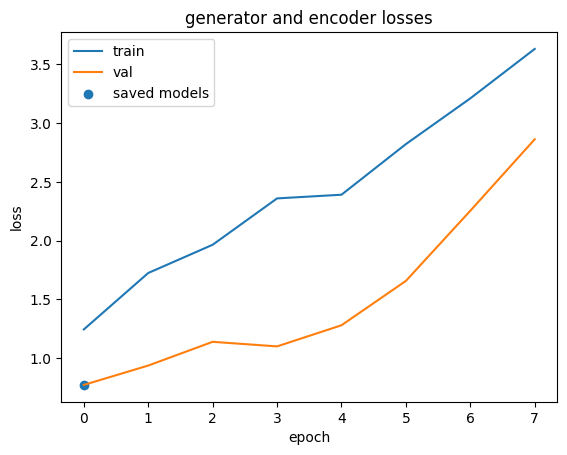

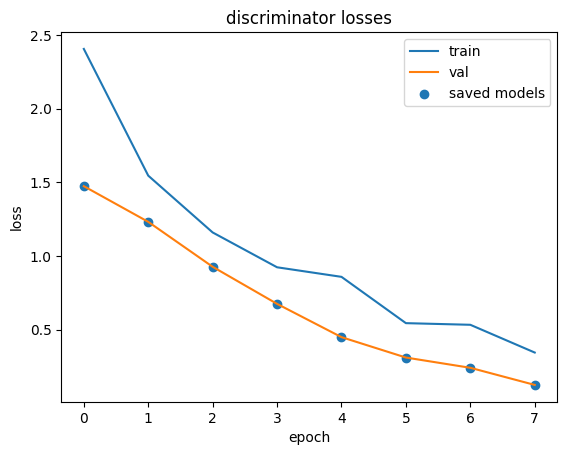

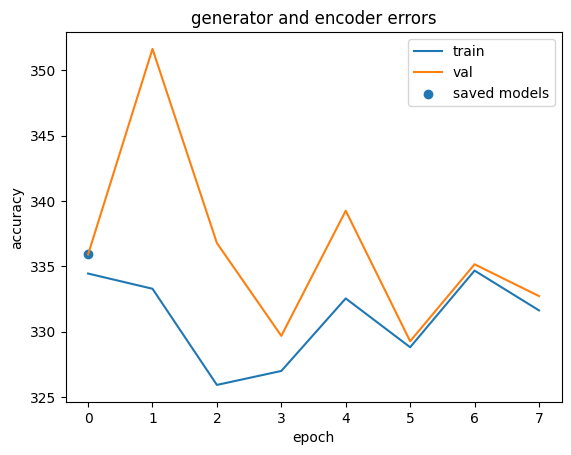

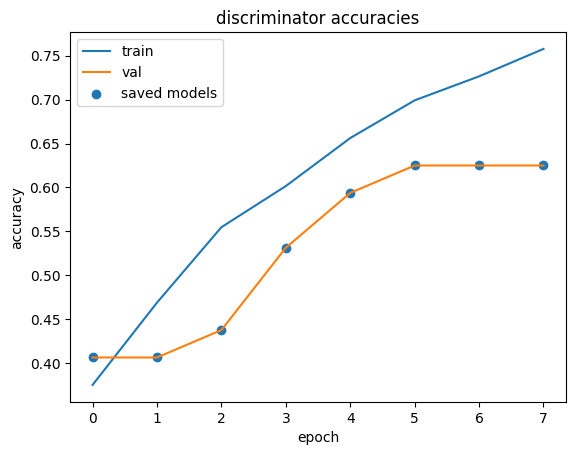

epoch 8 batch 0
real_image_batch.shape torch.Size([32, 1, 32, 512])
input_text_batch.shape torch.Size([32, 82])
torch.Size([32, 384]) torch.Size([32, 512])


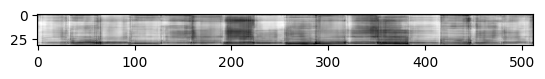

tensor([[0.0297],
        [0.0410],
        [0.1580],
        [0.1263],
        [0.0181],
        [0.0443],
        [0.0198],
        [0.1091],
        [0.3659],
        [0.1117],
        [0.0631],
        [0.1426],
        [0.1736],
        [0.3182],
        [0.0583],
        [0.0695],
        [0.0297],
        [0.1132],
        [0.1682],
        [0.1450],
        [0.0475],
        [0.0755],
        [0.1101],
        [0.2936],
        [0.0659],
        [0.1454],
        [0.6013],
        [0.3030],
        [0.1081],
        [0.0953],
        [0.0632],
        [0.0416]], grad_fn=<SigmoidBackward0>)
tensor([[0.9951],
        [0.9954],
        [0.9630],
        [0.9770],
        [0.9721],
        [0.9809],
        [0.9940],
        [0.9770],
        [0.9646],
        [0.9229],
        [0.9948],
        [0.9878],
        [0.9943],
        [0.9908],
        [0.9798],
        [0.9859],
        [0.9929],
        [0.9766],
        [0.9831],
        [0.9787],
        [0.9869],
        [0.9674],

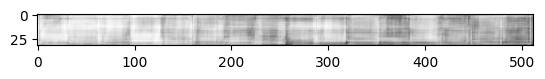

tensor([[3.0745e-04],
        [4.6273e-04],
        [3.2234e-05],
        [9.8277e-03],
        [7.3230e-03],
        [3.9160e-02],
        [3.3869e-02],
        [3.3148e-02],
        [1.0308e-02],
        [2.4575e-02],
        [5.5803e-03],
        [3.6775e-03],
        [4.8034e-04],
        [4.2818e-06],
        [1.1427e-02],
        [4.5574e-03],
        [1.3334e-02],
        [1.6824e-02],
        [8.7269e-04],
        [3.6305e-03],
        [1.5312e-02],
        [4.8139e-02],
        [3.4979e-02],
        [2.1623e-02],
        [1.6683e-02],
        [2.3972e-02],
        [2.6959e-02],
        [4.7292e-03],
        [5.3759e-02],
        [8.2038e-04],
        [6.4478e-06],
        [2.2074e-03]], grad_fn=<SigmoidBackward0>)
tensor([[0.7642],
        [0.9276],
        [0.9166],
        [0.8788],
        [0.8081],
        [0.8232],
        [0.5496],
        [0.3014],
        [0.8016],
        [0.9143],
        [0.6028],
        [0.7951],
        [0.2971],
        [0.9442],
        [0.7951

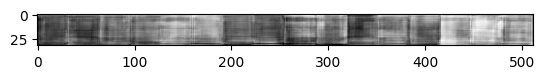

tensor([[1.0826e-01],
        [8.3239e-02],
        [1.9314e-02],
        [9.8917e-02],
        [3.5337e-01],
        [3.2558e-02],
        [1.2671e-01],
        [7.4848e-02],
        [3.2634e-02],
        [3.8755e-04],
        [6.3359e-02],
        [5.2854e-02],
        [6.2527e-02],
        [4.3250e-02],
        [1.6243e-01],
        [4.4474e-02],
        [2.5257e-01],
        [4.2022e-01],
        [8.5940e-03],
        [1.0634e-01],
        [9.9072e-02],
        [1.3620e-01],
        [1.7507e-01],
        [3.7640e-02],
        [1.0288e-02],
        [5.7967e-02],
        [1.2697e-01],
        [1.7351e-02],
        [3.9363e-02],
        [1.6730e-01],
        [1.5678e-02],
        [2.6295e-02]], grad_fn=<SigmoidBackward0>)
tensor([[0.9949],
        [0.9886],
        [0.9908],
        [0.9988],
        [0.9793],
        [0.9804],
        [0.9984],
        [0.9680],
        [0.9862],
        [0.9960],
        [0.9888],
        [0.9821],
        [0.9564],
        [0.9824],
        [0.9920

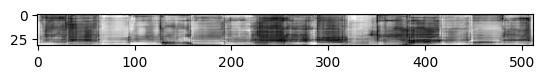

tensor([[0.0171],
        [0.0058],
        [0.0460],
        [0.0047]], grad_fn=<SigmoidBackward0>)
tensor([[0.9561],
        [0.9138],
        [0.8310],
        [0.8600]], grad_fn=<SigmoidBackward0>)
tensor(1)
tensor(1.9583, grad_fn=<BinaryCrossEntropyBackward0>)
tensor([[0.1584],
        [0.1094],
        [0.5406],
        [0.0395]], grad_fn=<SigmoidBackward0>)
Epoch 8:
	Generator and encoder train loss: 3.8578115105628967
	Discriminator train loss: 0.2509712651371956
	Generator and encoder train accuracy: 332.15411376953125
	Discriminator train accuracy: 0.76953125
	Generator and encoder val loss: 2.3829567432403564
	Discriminator val loss: 0.21747735142707825
	Generator and encoder val accuracy: 342.89617919921875
	Discriminator val accuracy: 0.609375


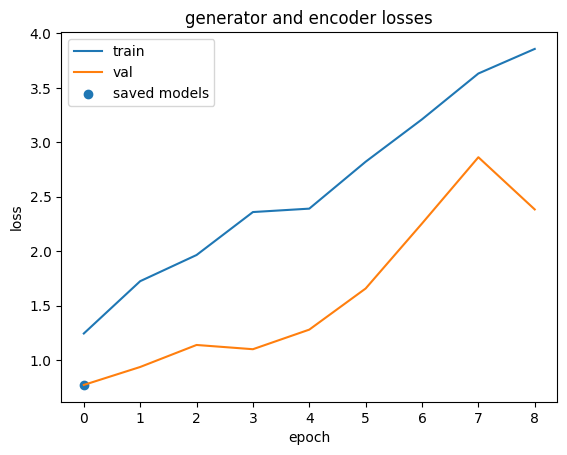

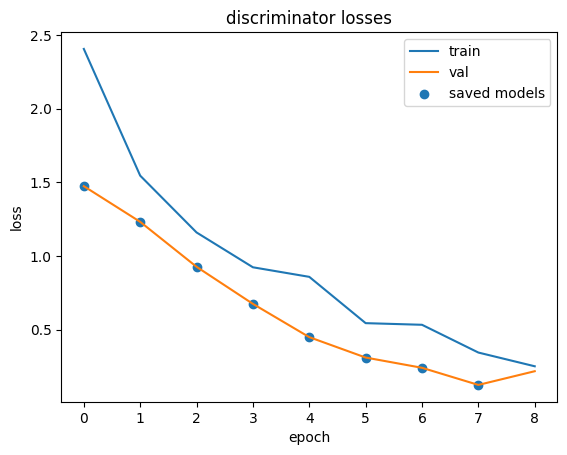

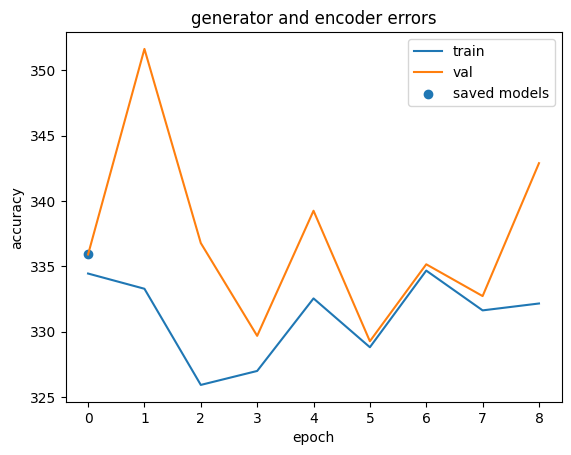

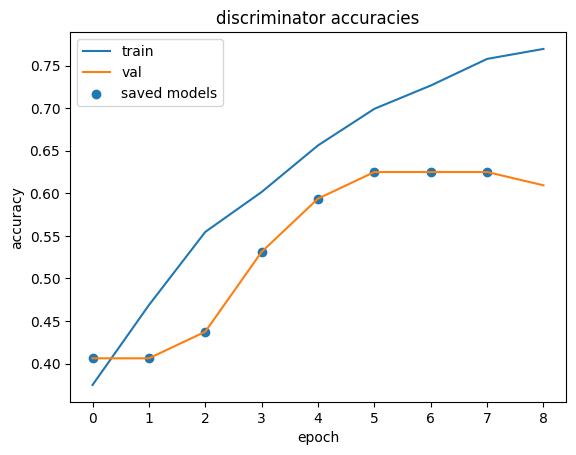

epoch 9 batch 0
real_image_batch.shape torch.Size([32, 1, 32, 512])
input_text_batch.shape torch.Size([32, 82])
torch.Size([32, 384]) torch.Size([32, 512])


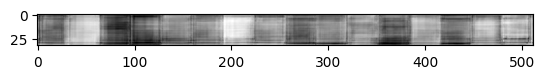

tensor([[0.1110],
        [0.1144],
        [0.0556],
        [0.2551],
        [0.1188],
        [0.1748],
        [0.0534],
        [0.0442],
        [0.0733],
        [0.2428],
        [0.0361],
        [0.0298],
        [0.5010],
        [0.0681],
        [0.4170],
        [0.4353],
        [0.0336],
        [0.2171],
        [0.0394],
        [0.0704],
        [0.0886],
        [0.0256],
        [0.0240],
        [0.0391],
        [0.0893],
        [0.1219],
        [0.0325],
        [0.0693],
        [0.2128],
        [0.0725],
        [0.3352],
        [0.0768]], grad_fn=<SigmoidBackward0>)
tensor([[0.9946],
        [0.9834],
        [0.9970],
        [0.9991],
        [0.9959],
        [0.9820],
        [0.9990],
        [0.9774],
        [0.9967],
        [0.9980],
        [0.9900],
        [0.9992],
        [0.9827],
        [0.9927],
        [0.9950],
        [0.9922],
        [0.9933],
        [0.9954],
        [0.9795],
        [0.9939],
        [0.9978],
        [0.9513],

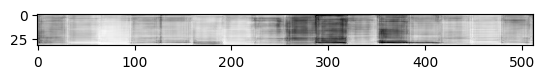

tensor([[9.4330e-05],
        [9.3266e-03],
        [4.1447e-03],
        [1.8624e-02],
        [4.4647e-04],
        [1.6129e-03],
        [1.6381e-02],
        [1.7875e-02],
        [1.0516e-02],
        [7.2868e-03],
        [5.1410e-03],
        [5.8523e-03],
        [1.5990e-02],
        [1.5156e-03],
        [1.5381e-02],
        [1.3073e-02],
        [1.4896e-02],
        [1.6848e-03],
        [2.9234e-03],
        [5.8682e-03],
        [4.6107e-03],
        [1.4490e-03],
        [4.8561e-03],
        [8.0273e-04],
        [1.7268e-02],
        [3.8643e-02],
        [8.6845e-05],
        [1.1973e-06],
        [7.3751e-03],
        [7.4195e-03],
        [2.3395e-03],
        [1.2069e-02]], grad_fn=<SigmoidBackward0>)
tensor([[0.7934],
        [0.9533],
        [0.8713],
        [0.9060],
        [0.8403],
        [0.8476],
        [0.7001],
        [0.8740],
        [0.8707],
        [0.8711],
        [0.8341],
        [0.9569],
        [0.5923],
        [0.8359],
        [0.8185

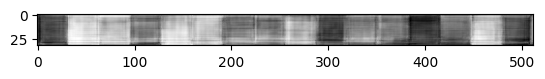

tensor([[0.0459],
        [0.2892],
        [0.0926],
        [0.0454],
        [0.0101],
        [0.1590],
        [0.3293],
        [0.1074],
        [0.0746],
        [0.0276],
        [0.0561],
        [0.0470],
        [0.0726],
        [0.0486],
        [0.0954],
        [0.0707],
        [0.1969],
        [0.0343],
        [0.0555],
        [0.0140],
        [0.0379],
        [0.0055],
        [0.2723],
        [0.0996],
        [0.1323],
        [0.0522],
        [0.0085],
        [0.0336],
        [0.2000],
        [0.2032],
        [0.2771],
        [0.0031]], grad_fn=<SigmoidBackward0>)
tensor([[0.9898],
        [0.9923],
        [0.9947],
        [0.9883],
        [0.9988],
        [0.9909],
        [0.9898],
        [0.9899],
        [0.9914],
        [0.9885],
        [0.9973],
        [0.9915],
        [0.9949],
        [0.9868],
        [0.9932],
        [0.9698],
        [0.9882],
        [0.9910],
        [0.9925],
        [0.9982],
        [0.9976],
        [0.9881],

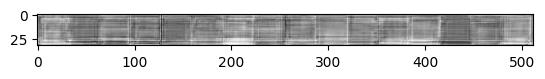

tensor([[0.0030],
        [0.0198],
        [0.0010],
        [0.0073]], grad_fn=<SigmoidBackward0>)
tensor([[0.9134],
        [0.9478],
        [0.9308],
        [0.8924]], grad_fn=<SigmoidBackward0>)
tensor(0)
tensor(2.5764, grad_fn=<BinaryCrossEntropyBackward0>)
tensor([[0.0283],
        [0.1489],
        [0.0362],
        [0.1984]], grad_fn=<SigmoidBackward0>)
Epoch 9:
	Generator and encoder train loss: 4.070061206817627
	Discriminator train loss: 0.21074406057596207
	Generator and encoder train accuracy: 329.9460144042969
	Discriminator train accuracy: 0.77734375
	Generator and encoder val loss: 2.4473063945770264
	Discriminator val loss: 0.1366209089756012
	Generator and encoder val accuracy: 325.86083984375
	Discriminator val accuracy: 0.625


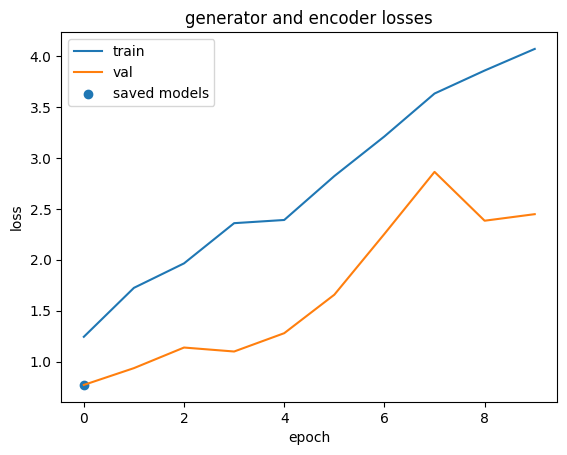

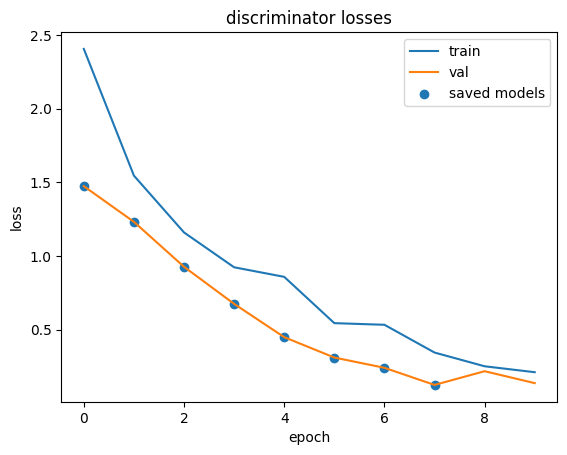

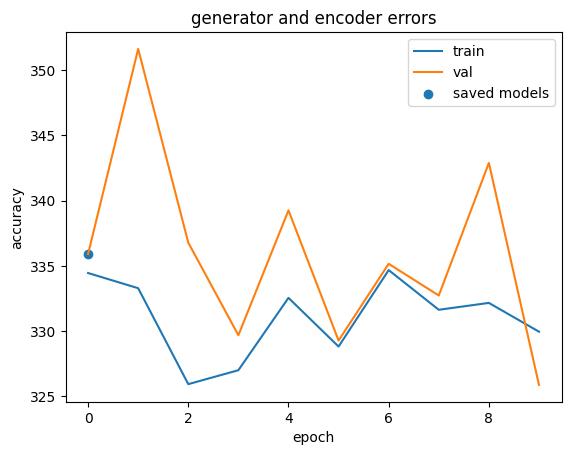

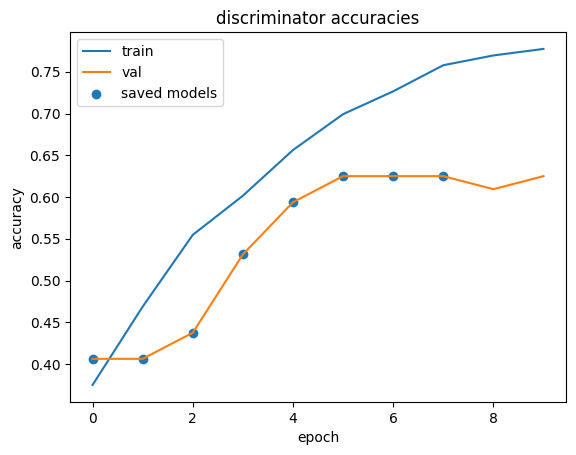

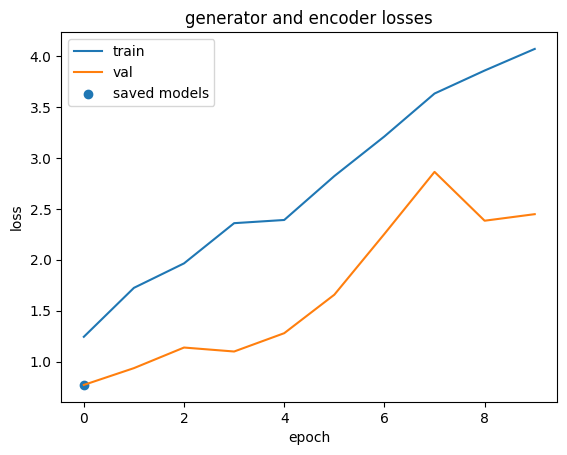

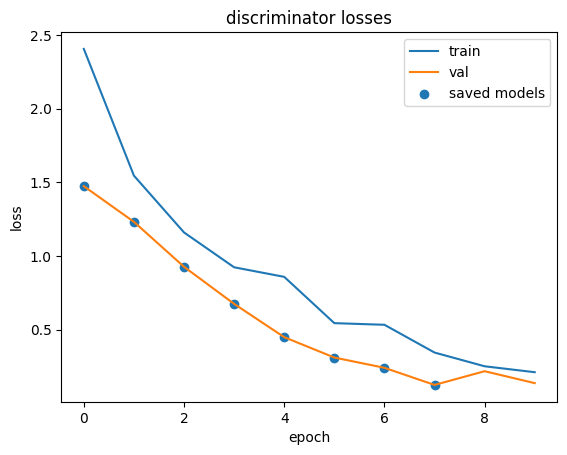

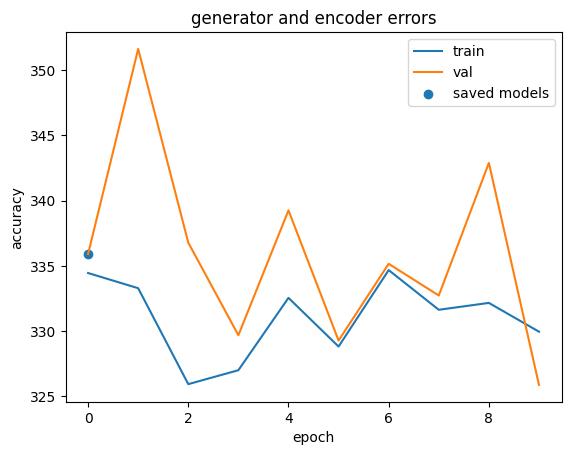

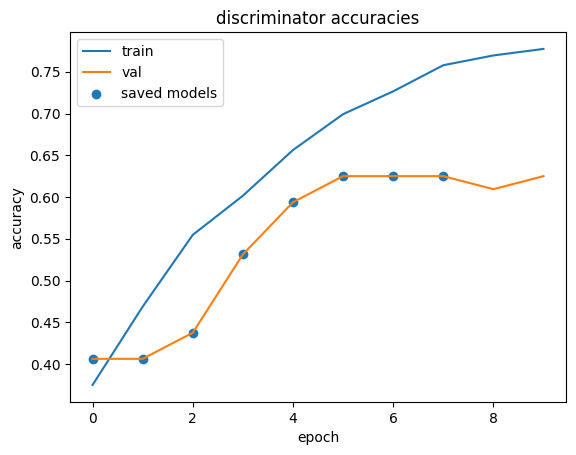

In [ ]:
generator = Generator()
discriminator = Discriminator()
encoder = Encoder()
# generator = load_model(generator, "main_model/model_snapshots/2023-07-13_18-06-43_bs4_lr0.0002_betas(0, 0.999)_generator_epoch9.pt")
# generator, encoder, discriminator = load_models_of_same_batch(generator, encoder, discriminator, filename_prefix="main_model/model_snapshots/2023-07-13_18-06-43_bs4_lr0.0002_betas(0, 0.999)", epoch_number=9)

train_gan(learning_rate=1e-5, num_epochs=10, batch_size=32, 
          encoder=encoder, generator=generator ,discriminator=discriminator, 
          train_real_image_dataset=line_image_dataset_train, val_real_image_dataset=line_image_dataset_val, 
          train_input_text_dataset=line_transcription_dataset_train, val_input_text_dataset=line_transcription_dataset_val, 
          recognizer=None)